In [ ]:
# This notebook is for training catboost models

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra/
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
import catboost as cb
import pickle

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
DIR = 'train_data_githubbed'

In [3]:
import glob
# change tag names to learn same model changing train and val halves. Increases score by 0.003
train_tag = 'train'
val_tag = 'valid'
train_dfs = []
for path in tqdm(glob.glob(f'{DIR}/{train_tag}_data*.pqt')):
    train_df_part = pd.read_parquet(path)
    train_dfs.append(train_df_part)
train_df = pd.concat(train_dfs)
train_df.loc[:, 'country'] = train_df.loc[:, 'country'].astype('category')
del train_dfs
val_df = pd.read_parquet(f'{DIR}/{val_tag}_data0.pqt')

import gc
gc.collect()

  0%|          | 0/7 [00:00<?, ?it/s]

21

### Feature generation

At some moment I realised that it's easier to generate features here rather than in preparation script, because it enhanced speed of testing hypotheses.

In [4]:
train_df.columns

Index(['id', 'match_id', 'kdist', 'kneighbors', 'found', 'kdist_name_0_1',
       'kneighbors_name_0_1', 'found_name_0_1', 'kdist_name_4',
       'kneighbors_name_4', 'found_name_4', 'kdist_country',
       'kneighbors_country', 'found_country', 'simple_sim', 'label', 'country',
       'longitude', 'latitude', 'h3_7', 'h3_7_density', 'haversine_dist',
       'euclidian_dist', 'country_avg_haversine', 'country_avg_haversine_diff',
       'country_avg_haversine_div', 'country_avg_neighbors', 'name_dist',
       'name_dist_cos', 'name_sim', 'name_gesh', 'name_leven', 'name_jaro',
       'name_lcs', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs',
       'address_sim', 'address_gesh', 'address_leven', 'address_jaro',
       'address_lcs', 'address_len_diff', 'address_nleven', 'address_nlcsk',
       'address_nlcs', 'city_gesh', 'city_leven', 'city_jaro', 'city_lcs',
       'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_sim',
       'state_gesh', 'state_leven', 

In [5]:
from foursquare_solution.tools.types_downcasting import cast_booleans, downcast_floats

boolean_cols = [col for col in train_df.columns if col.startswith('found')]
print(boolean_cols)
cast_booleans(train_df, boolean_cols)
downcast_floats(train_df)
cast_booleans(val_df, boolean_cols)
downcast_floats(val_df)

['found', 'found_name_0_1', 'found_name_4', 'found_country']


In [6]:
train_df.dtypes

id                   object
match_id             object
kdist               float32
kneighbors          float32
found                  bool
                     ...   
country_lcs         float32
country_len_diff    float32
country_nleven      float32
country_nlcsk       float32
country_nlcs        float32
Length: 99, dtype: object

In [7]:
import random

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

SEED = 2022
seed_everything(SEED)

In [8]:
id2ids_train = np.load(f'{DIR}/id2ids_{train_tag}.npy', allow_pickle=True).item()
id2ids_val = np.load(f'{DIR}/id2ids_{val_tag}.npy', allow_pickle=True).item()
print(set(id2ids_train) & set(id2ids_val))
id2ids = {k: v for dct in [id2ids_train, id2ids_val] for k, v in dct.items()}

set()


In [9]:
train_df.columns

Index(['id', 'match_id', 'kdist', 'kneighbors', 'found', 'kdist_name_0_1',
       'kneighbors_name_0_1', 'found_name_0_1', 'kdist_name_4',
       'kneighbors_name_4', 'found_name_4', 'kdist_country',
       'kneighbors_country', 'found_country', 'simple_sim', 'label', 'country',
       'longitude', 'latitude', 'h3_7', 'h3_7_density', 'haversine_dist',
       'euclidian_dist', 'country_avg_haversine', 'country_avg_haversine_diff',
       'country_avg_haversine_div', 'country_avg_neighbors', 'name_dist',
       'name_dist_cos', 'name_sim', 'name_gesh', 'name_leven', 'name_jaro',
       'name_lcs', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs',
       'address_sim', 'address_gesh', 'address_leven', 'address_jaro',
       'address_lcs', 'address_len_diff', 'address_nleven', 'address_nlcsk',
       'address_nlcs', 'city_gesh', 'city_leven', 'city_jaro', 'city_lcs',
       'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_sim',
       'state_gesh', 'state_leven', 

In [10]:
for some_df in [train_df, val_df]:
    some_df['inv_cos'] = np.maximum(1 - some_df['name_dist_cos'], 0) * 2
    some_df['comb_dist_01'] = some_df.euclidian_dist ** 2 * 0.01 + some_df.inv_cos
    some_df['comb_dist_4'] = some_df.euclidian_dist ** 2 * 16 + some_df.inv_cos
    some_df['comb_dist_10'] = some_df.euclidian_dist ** 2 * 100 + some_df.inv_cos
    downcast_floats(some_df)

In [11]:
data = pd.read_csv('train.csv').set_index('id')#.loc[id2ids_train]


In [12]:
cnt_solo = data.categories.str.split(', ').explode().value_counts()
cnt_solo

Cafés                                          32296
Residential Buildings (Apartments / Condos)    29268
Banks                                          25448
Offices                                        25310
Coffee Shops                                   25128
                                               ...  
Huaiyang Restaurants                               1
Ice Bars                                           1
Labour Canteens                                    1
Puglia Restaurants                                 1
Gilaki Restaurants                                 1
Name: categories, Length: 910, dtype: int64

In [13]:
categ_index = {k: idx for idx, k in enumerate(cnt_solo.index)}
with open(f'{DIR}/categ_index.pkl', 'wb') as f:  # Potential leak
    pickle.dump(categ_index, f)
categ_index['Banks']

2

In [14]:

data['categories_set'] = data.categories.str.split(', ').apply(
    lambda x: set() if isinstance(x, float) else set([categ_index[s] for s in x])
)

In [15]:
from itertools import combinations
cnt_pairs = pd.DataFrame(
    data.categories_set.apply(lambda x: list(combinations(sorted(set(x)), 2))).explode().value_counts(),
).reset_index()
cnt_pairs


,index,categories_set
0,"(0, 4)",4500
1,"(18, 19)",3800
2,"(25, 33)",2619
3,"(8, 44)",2578
4,"(3, 7)",2433
...,...,...
25601,"(244, 665)",1
25602,"(98, 377)",1
25603,"(21, 293)",1
25604,"(82, 293)",1


In [16]:
cnt_pairs = cnt_pairs
cnt_pairs['cat1'] = cnt_pairs['index'].apply(lambda x: x[0])
cnt_pairs['cat2'] = cnt_pairs['index'].apply(lambda x: x[1])
cnt_pairs

,index,categories_set,cat1,cat2
0,"(0, 4)",4500,0,4
1,"(18, 19)",3800,18,19
2,"(25, 33)",2619,25,33
3,"(8, 44)",2578,8,44
4,"(3, 7)",2433,3,7
...,...,...,...,...
25601,"(244, 665)",1,244,665
25602,"(98, 377)",1,98,377
25603,"(21, 293)",1,21,293
25604,"(82, 293)",1,82,293


In [17]:
cnt_solo.index = cnt_solo.index.map(categ_index)

In [18]:
cnt_pairs['cat1cnt'] = cnt_solo[cnt_pairs.cat1].values
cnt_pairs['cat2cnt'] = cnt_solo[cnt_pairs.cat2].values
cnt_pairs['jaccard'] = cnt_pairs.categories_set/(cnt_pairs.cat1cnt+cnt_pairs.cat2cnt-cnt_pairs.categories_set)
cnt_pairs

,index,categories_set,cat1,cat2,cat1cnt,cat2cnt,jaccard
0,"(0, 4)",4500,0,4,32296,25128,0.085028
1,"(18, 19)",3800,18,19,12156,11431,0.192045
2,"(25, 33)",2619,25,33,9876,8166,0.169811
3,"(8, 44)",2578,8,44,19828,6456,0.108749
4,"(3, 7)",2433,3,7,25310,19976,0.056775
...,...,...,...,...,...,...,...
25601,"(244, 665)",1,244,665,1081,62,0.000876
25602,"(98, 377)",1,98,377,3655,463,0.000243
25603,"(21, 293)",1,21,293,10755,754,0.000087
25604,"(82, 293)",1,82,293,4405,754,0.000194


In [19]:
cnt_pairs = cnt_pairs[
    (cnt_pairs.cat1cnt > 50) 
    & (cnt_pairs.cat2cnt > 50) 
    #& (cnt_pairs.categories_set > 50)
].sort_values('jaccard', ascending=False)
cnt_pairs.head()

,index,categories_set,cat1,cat2,cat1cnt,cat2cnt,jaccard
22,"(122, 149)",1059,122,149,2634,2218,0.279199
1,"(18, 19)",3800,18,19,12156,11431,0.192045
884,"(504, 516)",62,504,516,202,185,0.190769
563,"(387, 535)",96,387,535,432,172,0.188976
128,"(204, 297)",317,204,297,1402,732,0.174463


In [20]:
categ2jaccards = cnt_pairs.set_index('index')['jaccard'].to_dict()
categ2jaccards.update({(k[1], k[0]): v for k, v in categ2jaccards.items()})
categ2jaccards

{(122, 149): 0.2791985235960981,
 (18, 19): 0.19204528225602668,
 (504, 516): 0.19076923076923077,
 (387, 535): 0.1889763779527559,
 (204, 297): 0.17446340121078702,
 (25, 33): 0.16981132075471697,
 (85, 109): 0.1520167121966897,
 (238, 273): 0.15005861664712777,
 (128, 257): 0.14068564036222508,
 (449, 502): 0.1359447004608295,
 (180, 285): 0.133920296570899,
 (16, 122): 0.11754094812035501,
 (8, 44): 0.10874883995612925,
 (8, 76): 0.10711542805511633,
 (46, 60): 0.10366482331989878,
 (16, 149): 0.10360987039613385,
 (169, 271): 0.10032493907392363,
 (37, 103): 0.09977669508729192,
 (16, 79): 0.09723449930546786,
 (285, 398): 0.09624197983501374,
 (254, 404): 0.09461663947797716,
 (15, 62): 0.09382045204925141,
 (519, 611): 0.09266409266409266,
 (123, 358): 0.09094052558782849,
 (485, 555): 0.08959537572254335,
 (340, 479): 0.08690012970168612,
 (0, 4): 0.08502758672813847,
 (225, 271): 0.08416100365917407,
 (287, 470): 0.08350951374207188,
 (77, 244): 0.081640331075997,
 (8, 41): 0.0

In [21]:
with open(f'{DIR}/categ2jac.pkl', 'wb') as f:  # Potential leak
    pickle.dump(categ2jaccards, f)

In [22]:
from itertools import product

def jaccard(set1, set2):
    if not set1 and not set2:
        return 0
    inters_len = len(set1 & set2)
    return inters_len / (len(set1) + len(set2) - inters_len)

def intersection_len(set1, set2):
    return len(set1 & set2)

def best_intersection(set1, set2, jaccard_map):
    # идея - если есть пересечение то 1, если нет - лучший из жаккаров
    if not set1 and not set2:
        return 0
    if len(set1 & set2) > 0:
        return 1.0
    jaccards = []
    for ob1, ob2 in product(set1, set2):
        jaccards.append(jaccard_map.get((ob1, ob2), 0.0))
    if not jaccards:
        return 0
    return max(jaccards)

def avg_intersection(set1, set2, jaccard_map):
    # идея - если есть пересечение то 1, если нет - лучший из жаккаров
    if not set1 and not set2:
        return 0
    jaccards = []
    for ob1, ob2 in product(set1, set2):
        if ob1 == ob2:
            jaccards.append(1)
        jaccards.append(jaccard_map.get((ob1, ob2), 0.0))
    if not jaccards:
        return 0
    return np.mean(jaccards)


In [23]:
for some_df in [train_df, val_df]:
    some_df['categories_set'] = data.loc[some_df.id, 'categories_set'].values
    some_df['categories_set_match'] = data.loc[some_df.match_id, 'categories_set'].values
    some_df['categories_jaccard'] = [jaccard(x, y) for x, y in zip(some_df.categories_set, some_df.categories_set_match)]
    some_df['categories_intlen'] = [intersection_len(x, y) for x, y in zip(some_df.categories_set, some_df.categories_set_match)]
    some_df['categories_intbest'] = [best_intersection(x, y, categ2jaccards) for x, y in zip(some_df.categories_set, some_df.categories_set_match)]
    some_df['categories_intavg'] = [avg_intersection(x, y, categ2jaccards) for x, y in zip(some_df.categories_set, some_df.categories_set_match)]

In [24]:
dist_cols_asc = [
    ('comb_dist_01', True),
    ('comb_dist_4', True),
    ('comb_dist_10', True),
    ('haversine_dist', True),
    ('euclidian_dist', True),
    ('name_dist', False),
    ('name_dist_cos', False),
    ('simple_sim', False),
    ('address_gesh', False),
    ('address_sim', False),
    ('categories_sim', False),
    ('name_sim', False)
]

dist_cols = [
    col for col, _ in dist_cols_asc
]
train_df[dist_cols].isna().sum(0)

comb_dist_01             0
comb_dist_4              0
comb_dist_10             0
haversine_dist           0
euclidian_dist           0
name_dist                0
name_dist_cos            0
simple_sim               0
address_gesh      13496091
address_sim              0
categories_sim           0
name_sim                 0
dtype: int64

In [25]:
train_df['address_gesh'] = train_df['address_gesh'].fillna(2)
val_df['address_gesh'] = val_df['address_gesh'].fillna(2)

In [26]:
train_df[['id', 'match_id', 'label'] + dist_cols]

,id,match_id,label,comb_dist_01,comb_dist_4,comb_dist_10,haversine_dist,euclidian_dist,name_dist,name_dist_cos,simple_sim,address_gesh,address_sim,categories_sim,name_sim
1932803,E_24749fec1c6f0c,E_24749fec1c6f0c,1,0.000000,0.000000,0.000000,0.000000,0.000000,90.756157,1.000000,4,1.000000,1.000000,1.000000,1.000000
1932804,E_24749fec1c6f0c,E_84b7b8957c14a5,1,0.055367,0.055369,0.055380,0.000005,0.000364,88.231705,0.972317,3,1.000000,1.000000,1.000000,0.929187
1932805,E_24749fec1c6f0c,E_5dcd1d8fe78726,0,0.629230,0.630968,0.640096,0.000162,0.010425,61.912060,0.685385,0,0.457143,0.081408,0.000000,0.000000
1932806,E_24749fec1c6f0c,E_47bba3dc8137dd,0,0.629230,0.631167,0.641344,0.000170,0.011007,61.912060,0.685385,0,0.457143,0.081408,0.000000,0.000000
1932807,E_24749fec1c6f0c,E_66418d5323c72f,0,0.772069,0.776262,0.798288,0.000260,0.016193,60.227631,0.613967,0,0.388889,0.000000,0.106723,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26334403,E_db415db8ddbd5c,E_acc692ad8ebe99,0,0.156586,250.537933,1565.862061,0.054122,3.957098,90.520187,1.000000,3,0.545455,0.000000,1.000000,1.000000
26334404,E_db415db8ddbd5c,E_37b809e72bb93e,0,0.109231,174.769775,1092.311035,0.053416,3.305013,90.520187,1.000000,3,0.127660,0.000000,1.000000,1.000000
26334405,E_db415db8ddbd5c,E_36d016326bf00c,0,0.104133,166.612518,1041.328247,0.051999,3.226962,90.520187,1.000000,3,0.133333,0.000000,1.000000,1.000000
26334406,E_db415db8ddbd5c,E_bae527f948f09c,0,0.208367,333.386505,2083.665771,0.077278,4.564719,90.520187,1.000000,3,0.205128,0.000000,1.000000,1.000000


In [27]:
for some_df in [train_df, val_df]:
    rank_dist_cols = []
    for col, asc in tqdm(dist_cols_asc):
        rank_dist_col_name = 'rank_' + col
        some_df.loc[:, rank_dist_col_name] = some_df.groupby('id')[col].rank(
            method='dense', ascending=True # asc - didn't add score
        ).astype(int)
        rank_dist_cols.append(rank_dist_col_name)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [28]:
# some categories were trimmed due to small shap values

In [29]:
cat_features = ['country']

train_cols = [
    'kdist', 'kneighbors', 'found', 
    'kdist_name_0_1', 'kdist_name_4',
    'kneighbors_name_0_1', 'kneighbors_name_4',
    'found_name_0_1','found_name_4', 
    'kdist_country', 'kneighbors_country',
    'found_country', 'simple_sim', 'haversine_dist', 'country', 'euclidian_dist', 
    
    'name_dist',  'name_dist_cos', 'name_sim', 'name_gesh', 'name_leven', 'name_jaro', 'name_lcs', 
    'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 
    
    'address_sim', 'address_gesh', 'address_leven', 'address_jaro', 'address_lcs', 
    'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 
    
    'city_gesh', 'city_leven', 'city_jaro', 'city_lcs', 
    'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 
    
    'state_sim', 'state_gesh', 'state_leven','state_jaro', 'state_lcs', 
    'state_len_diff', 'state_nleven',
    
    'zip_gesh', 'zip_leven', 'zip_jaro', 'zip_lcs', 
    
    'url_sim', 'url_gesh', 'url_leven', 'url_jaro', 'url_lcs',
    'url_len_diff', 'url_nleven', 
    
    'phone_gesh', 'phone_leven', 'phone_jaro', 'phone_lcs',
    
    'categories_sim', 'categories_gesh', 'categories_leven', 'categories_jaro', 'categories_lcs',
    'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categories_nlcs', 
    
    'country_sim', 'country_nlcs',
    
    'country_avg_haversine', 'country_avg_haversine_diff','country_avg_haversine_div', 'country_avg_neighbors', 
    'h3_7_density',
    'comb_dist_01', 'comb_dist_4', 'comb_dist_10',
    'categories_jaccard', 'categories_intlen', 'categories_intbest', 'categories_intavg'
] + rank_dist_cols

In [ ]:
train_df[train_cols + ['id', 'match_id', 'label']].to_parquet(f'{DIR}/train.pqt')

In [30]:
train_df[cat_features].dtypes

country    category
dtype: object

### Training

In [31]:
train_pool = cb.Pool(
    train_df[train_cols],
    label=train_df.label.values,
    feature_names=train_cols,
    cat_features=cat_features,
)
             
val_pool = cb.Pool(
    val_df[train_cols], 
    label=val_df.label.values, 
    cat_features=cat_features,
    feature_names=train_cols,
)

In [32]:
1

1

In [34]:
model = cb.CatBoostClassifier(
    iterations=5000,
    learning_rate=0.01,
    depth=12,
    nan_mode='Max', 
    task_type="GPU",
    od_type="Iter", 
    od_wait=50,
    reg_lambda=5,
    gpu_ram_part=0.98,  # I had problems with GPU memory(RTX 3060) sometimes
    train_dir = f"{DIR}/catboost_logs/cb_model_gh",
)
model.fit(
    train_pool,
    eval_set=[val_pool],
    plot=True,
)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6791400	test: 0.6791457	best: 0.6791457 (0)	total: 664ms	remaining: 55m 21s
1:	learn: 0.6655073	test: 0.6655165	best: 0.6655165 (1)	total: 1.63s	remaining: 1h 7m 57s
2:	learn: 0.6522509	test: 0.6522802	best: 0.6522802 (2)	total: 2.54s	remaining: 1h 10m 26s
3:	learn: 0.6393436	test: 0.6393829	best: 0.6393829 (3)	total: 3.23s	remaining: 1h 7m 18s
4:	learn: 0.6267891	test: 0.6268427	best: 0.6268427 (4)	total: 4s	remaining: 1h 6m 39s
5:	learn: 0.6145786	test: 0.6146377	best: 0.6146377 (5)	total: 4.95s	remaining: 1h 8m 38s
6:	learn: 0.6027181	test: 0.6027879	best: 0.6027879 (6)	total: 5.55s	remaining: 1h 5m 59s
7:	learn: 0.5911844	test: 0.5912595	best: 0.5912595 (7)	total: 6.06s	remaining: 1h 3m 4s
8:	learn: 0.5799657	test: 0.5800538	best: 0.5800538 (8)	total: 6.82s	remaining: 1h 2m 59s
9:	learn: 0.5691104	test: 0.5692028	best: 0.5692028 (9)	total: 7.3s	remaining: 1h 41s
10:	learn: 0.5585127	test: 0.5586150	best: 0.5586150 (10)	total: 7.94s	remaining: 1h 3s
11:	learn: 0.5482015	

90:	learn: 0.1674498	test: 0.1678186	best: 0.1678186 (90)	total: 1m 33s	remaining: 1h 23m 46s
91:	learn: 0.1650676	test: 0.1654365	best: 0.1654365 (91)	total: 1m 34s	remaining: 1h 24m 14s
92:	learn: 0.1630432	test: 0.1634102	best: 0.1634102 (92)	total: 1m 36s	remaining: 1h 24m 45s
93:	learn: 0.1607934	test: 0.1611599	best: 0.1611599 (93)	total: 1m 37s	remaining: 1h 25m 8s
94:	learn: 0.1586008	test: 0.1589677	best: 0.1589677 (94)	total: 1m 39s	remaining: 1h 25m 33s
95:	learn: 0.1564767	test: 0.1568446	best: 0.1568446 (95)	total: 1m 40s	remaining: 1h 25m 54s
96:	learn: 0.1546766	test: 0.1550412	best: 0.1550412 (96)	total: 1m 42s	remaining: 1h 26m 15s
97:	learn: 0.1526743	test: 0.1530393	best: 0.1530393 (97)	total: 1m 43s	remaining: 1h 26m 39s
98:	learn: 0.1507391	test: 0.1511039	best: 0.1511039 (98)	total: 1m 45s	remaining: 1h 26m 59s
99:	learn: 0.1488351	test: 0.1492002	best: 0.1492002 (99)	total: 1m 46s	remaining: 1h 27m 19s
100:	learn: 0.1472197	test: 0.1475831	best: 0.1475831 (100)	t

176:	learn: 0.0874691	test: 0.0878508	best: 0.0878508 (176)	total: 3m 45s	remaining: 1h 42m 22s
177:	learn: 0.0871121	test: 0.0874919	best: 0.0874919 (177)	total: 3m 46s	remaining: 1h 42m 25s
178:	learn: 0.0867643	test: 0.0871425	best: 0.0871425 (178)	total: 3m 48s	remaining: 1h 42m 33s
179:	learn: 0.0864608	test: 0.0868405	best: 0.0868405 (179)	total: 3m 50s	remaining: 1h 42m 40s
180:	learn: 0.0861173	test: 0.0864952	best: 0.0864952 (180)	total: 3m 51s	remaining: 1h 42m 48s
181:	learn: 0.0858261	test: 0.0862060	best: 0.0862060 (181)	total: 3m 53s	remaining: 1h 42m 56s
182:	learn: 0.0854953	test: 0.0858737	best: 0.0858737 (182)	total: 3m 54s	remaining: 1h 43m 4s
183:	learn: 0.0851728	test: 0.0855491	best: 0.0855491 (183)	total: 3m 56s	remaining: 1h 43m 11s
184:	learn: 0.0848948	test: 0.0852738	best: 0.0852738 (184)	total: 3m 58s	remaining: 1h 43m 19s
185:	learn: 0.0846379	test: 0.0850163	best: 0.0850163 (185)	total: 3m 59s	remaining: 1h 43m 22s
186:	learn: 0.0843247	test: 0.0847014	bes

262:	learn: 0.0705190	test: 0.0708176	best: 0.0708176 (262)	total: 6m	remaining: 1h 48m 17s
263:	learn: 0.0704351	test: 0.0707341	best: 0.0707341 (263)	total: 6m 2s	remaining: 1h 48m 17s
264:	learn: 0.0703085	test: 0.0706054	best: 0.0706054 (264)	total: 6m 3s	remaining: 1h 48m 20s
265:	learn: 0.0701845	test: 0.0704791	best: 0.0704791 (265)	total: 6m 5s	remaining: 1h 48m 21s
266:	learn: 0.0700865	test: 0.0703831	best: 0.0703831 (266)	total: 6m 6s	remaining: 1h 48m 23s
267:	learn: 0.0699661	test: 0.0702607	best: 0.0702607 (267)	total: 6m 8s	remaining: 1h 48m 25s
268:	learn: 0.0698483	test: 0.0701409	best: 0.0701409 (268)	total: 6m 10s	remaining: 1h 48m 29s
269:	learn: 0.0697506	test: 0.0700445	best: 0.0700445 (269)	total: 6m 11s	remaining: 1h 48m 29s
270:	learn: 0.0696586	test: 0.0699538	best: 0.0699538 (270)	total: 6m 13s	remaining: 1h 48m 31s
271:	learn: 0.0695766	test: 0.0698715	best: 0.0698715 (271)	total: 6m 14s	remaining: 1h 48m 34s
272:	learn: 0.0694645	test: 0.0697572	best: 0.069

348:	learn: 0.0620636	test: 0.0623152	best: 0.0623152 (348)	total: 8m 19s	remaining: 1h 50m 52s
349:	learn: 0.0619151	test: 0.0621677	best: 0.0621677 (349)	total: 8m 20s	remaining: 1h 50m 55s
350:	learn: 0.0617715	test: 0.0620254	best: 0.0620254 (350)	total: 8m 22s	remaining: 1h 50m 58s
351:	learn: 0.0617129	test: 0.0619690	best: 0.0619690 (351)	total: 8m 24s	remaining: 1h 50m 58s
352:	learn: 0.0616142	test: 0.0618725	best: 0.0618725 (352)	total: 8m 26s	remaining: 1h 51m 1s
353:	learn: 0.0614718	test: 0.0617308	best: 0.0617308 (353)	total: 8m 27s	remaining: 1h 51m 4s
354:	learn: 0.0614187	test: 0.0616802	best: 0.0616802 (354)	total: 8m 29s	remaining: 1h 51m 5s
355:	learn: 0.0612804	test: 0.0615416	best: 0.0615416 (355)	total: 8m 31s	remaining: 1h 51m 7s
356:	learn: 0.0612264	test: 0.0614887	best: 0.0614887 (356)	total: 8m 32s	remaining: 1h 51m 7s
357:	learn: 0.0611323	test: 0.0613974	best: 0.0613974 (357)	total: 8m 34s	remaining: 1h 51m 10s
358:	learn: 0.0610063	test: 0.0612726	best: 0

434:	learn: 0.0558102	test: 0.0561460	best: 0.0561460 (434)	total: 10m 44s	remaining: 1h 52m 45s
435:	learn: 0.0557392	test: 0.0560780	best: 0.0560780 (435)	total: 10m 46s	remaining: 1h 52m 47s
436:	learn: 0.0556762	test: 0.0560152	best: 0.0560152 (436)	total: 10m 48s	remaining: 1h 52m 48s
437:	learn: 0.0556064	test: 0.0559485	best: 0.0559485 (437)	total: 10m 50s	remaining: 1h 52m 50s
438:	learn: 0.0555876	test: 0.0559280	best: 0.0559280 (438)	total: 10m 51s	remaining: 1h 52m 50s
439:	learn: 0.0555447	test: 0.0558847	best: 0.0558847 (439)	total: 10m 53s	remaining: 1h 52m 51s
440:	learn: 0.0555155	test: 0.0558570	best: 0.0558570 (440)	total: 10m 54s	remaining: 1h 52m 51s
441:	learn: 0.0554976	test: 0.0558377	best: 0.0558377 (441)	total: 10m 56s	remaining: 1h 52m 52s
442:	learn: 0.0553968	test: 0.0557427	best: 0.0557427 (442)	total: 10m 58s	remaining: 1h 52m 55s
443:	learn: 0.0553304	test: 0.0556795	best: 0.0556795 (443)	total: 11m	remaining: 1h 52m 56s
444:	learn: 0.0552673	test: 0.0556

519:	learn: 0.0514639	test: 0.0519347	best: 0.0519347 (519)	total: 13m 19s	remaining: 1h 54m 48s
520:	learn: 0.0514533	test: 0.0519229	best: 0.0519229 (520)	total: 13m 21s	remaining: 1h 54m 48s
521:	learn: 0.0513864	test: 0.0518586	best: 0.0518586 (521)	total: 13m 23s	remaining: 1h 54m 52s
522:	learn: 0.0513046	test: 0.0517827	best: 0.0517827 (522)	total: 13m 25s	remaining: 1h 54m 54s
523:	learn: 0.0512459	test: 0.0517272	best: 0.0517272 (523)	total: 13m 27s	remaining: 1h 54m 57s
524:	learn: 0.0512261	test: 0.0517071	best: 0.0517071 (524)	total: 13m 29s	remaining: 1h 54m 57s
525:	learn: 0.0511464	test: 0.0516328	best: 0.0516328 (525)	total: 13m 31s	remaining: 1h 55m 1s
526:	learn: 0.0511197	test: 0.0516077	best: 0.0516077 (526)	total: 13m 32s	remaining: 1h 55m
527:	learn: 0.0510592	test: 0.0515518	best: 0.0515518 (527)	total: 13m 34s	remaining: 1h 55m 2s
528:	learn: 0.0509931	test: 0.0514884	best: 0.0514884 (528)	total: 13m 36s	remaining: 1h 55m 3s
529:	learn: 0.0509376	test: 0.0514355

604:	learn: 0.0481143	test: 0.0487696	best: 0.0487696 (604)	total: 15m 59s	remaining: 1h 56m 13s
605:	learn: 0.0480916	test: 0.0487479	best: 0.0487479 (605)	total: 16m 1s	remaining: 1h 56m 12s
606:	learn: 0.0480536	test: 0.0487118	best: 0.0487118 (606)	total: 16m 3s	remaining: 1h 56m 15s
607:	learn: 0.0480293	test: 0.0486875	best: 0.0486875 (607)	total: 16m 5s	remaining: 1h 56m 16s
608:	learn: 0.0480040	test: 0.0486636	best: 0.0486636 (608)	total: 16m 7s	remaining: 1h 56m 16s
609:	learn: 0.0479792	test: 0.0486399	best: 0.0486399 (609)	total: 16m 9s	remaining: 1h 56m 16s
610:	learn: 0.0479524	test: 0.0486140	best: 0.0486140 (610)	total: 16m 11s	remaining: 1h 56m 16s
611:	learn: 0.0479033	test: 0.0485683	best: 0.0485683 (611)	total: 16m 13s	remaining: 1h 56m 17s
612:	learn: 0.0478928	test: 0.0485575	best: 0.0485575 (612)	total: 16m 14s	remaining: 1h 56m 16s
613:	learn: 0.0478825	test: 0.0485467	best: 0.0485467 (613)	total: 16m 16s	remaining: 1h 56m 15s
614:	learn: 0.0478559	test: 0.04852

690:	learn: 0.0458612	test: 0.0466304	best: 0.0466304 (690)	total: 18m 35s	remaining: 1h 55m 58s
691:	learn: 0.0458468	test: 0.0466165	best: 0.0466165 (691)	total: 18m 37s	remaining: 1h 55m 57s
692:	learn: 0.0458427	test: 0.0466127	best: 0.0466127 (692)	total: 18m 39s	remaining: 1h 55m 55s
693:	learn: 0.0458363	test: 0.0466060	best: 0.0466060 (693)	total: 18m 40s	remaining: 1h 55m 54s
694:	learn: 0.0458101	test: 0.0465813	best: 0.0465813 (694)	total: 18m 42s	remaining: 1h 55m 56s
695:	learn: 0.0457816	test: 0.0465549	best: 0.0465549 (695)	total: 18m 44s	remaining: 1h 55m 55s
696:	learn: 0.0457665	test: 0.0465409	best: 0.0465409 (696)	total: 18m 46s	remaining: 1h 55m 54s
697:	learn: 0.0457514	test: 0.0465269	best: 0.0465269 (697)	total: 18m 48s	remaining: 1h 55m 53s
698:	learn: 0.0457476	test: 0.0465232	best: 0.0465232 (698)	total: 18m 49s	remaining: 1h 55m 51s
699:	learn: 0.0457272	test: 0.0465041	best: 0.0465041 (699)	total: 18m 51s	remaining: 1h 55m 52s
700:	learn: 0.0456931	test: 0.

775:	learn: 0.0445705	test: 0.0454010	best: 0.0454010 (775)	total: 21m 5s	remaining: 1h 54m 48s
776:	learn: 0.0445428	test: 0.0453740	best: 0.0453740 (776)	total: 21m 7s	remaining: 1h 54m 48s
777:	learn: 0.0445278	test: 0.0453599	best: 0.0453599 (777)	total: 21m 9s	remaining: 1h 54m 48s
778:	learn: 0.0445139	test: 0.0453465	best: 0.0453465 (778)	total: 21m 11s	remaining: 1h 54m 47s
779:	learn: 0.0445114	test: 0.0453443	best: 0.0453443 (779)	total: 21m 12s	remaining: 1h 54m 45s
780:	learn: 0.0445068	test: 0.0453392	best: 0.0453392 (780)	total: 21m 14s	remaining: 1h 54m 44s
781:	learn: 0.0444850	test: 0.0453186	best: 0.0453186 (781)	total: 21m 16s	remaining: 1h 54m 42s
782:	learn: 0.0444825	test: 0.0453163	best: 0.0453163 (782)	total: 21m 17s	remaining: 1h 54m 40s
783:	learn: 0.0444650	test: 0.0452992	best: 0.0452992 (783)	total: 21m 19s	remaining: 1h 54m 39s
784:	learn: 0.0444625	test: 0.0452971	best: 0.0452971 (784)	total: 21m 20s	remaining: 1h 54m 37s
785:	learn: 0.0444578	test: 0.045

860:	learn: 0.0436448	test: 0.0445106	best: 0.0445106 (860)	total: 23m 34s	remaining: 1h 53m 18s
861:	learn: 0.0436264	test: 0.0444928	best: 0.0444928 (861)	total: 23m 35s	remaining: 1h 53m 17s
862:	learn: 0.0436036	test: 0.0444699	best: 0.0444699 (862)	total: 23m 38s	remaining: 1h 53m 17s
863:	learn: 0.0436016	test: 0.0444683	best: 0.0444683 (863)	total: 23m 39s	remaining: 1h 53m 16s
864:	learn: 0.0435907	test: 0.0444575	best: 0.0444575 (864)	total: 23m 41s	remaining: 1h 53m 15s
865:	learn: 0.0435689	test: 0.0444357	best: 0.0444357 (865)	total: 23m 43s	remaining: 1h 53m 15s
866:	learn: 0.0435670	test: 0.0444341	best: 0.0444341 (866)	total: 23m 45s	remaining: 1h 53m 13s
867:	learn: 0.0435651	test: 0.0444327	best: 0.0444327 (867)	total: 23m 46s	remaining: 1h 53m 11s
868:	learn: 0.0435474	test: 0.0444157	best: 0.0444157 (868)	total: 23m 48s	remaining: 1h 53m 10s
869:	learn: 0.0435390	test: 0.0444077	best: 0.0444077 (869)	total: 23m 50s	remaining: 1h 53m 9s
870:	learn: 0.0435374	test: 0.0

945:	learn: 0.0428074	test: 0.0437189	best: 0.0437189 (945)	total: 26m 3s	remaining: 1h 51m 39s
946:	learn: 0.0427979	test: 0.0437113	best: 0.0437113 (946)	total: 26m 5s	remaining: 1h 51m 38s
947:	learn: 0.0427772	test: 0.0436899	best: 0.0436899 (947)	total: 26m 7s	remaining: 1h 51m 39s
948:	learn: 0.0427742	test: 0.0436866	best: 0.0436866 (948)	total: 26m 8s	remaining: 1h 51m 37s
949:	learn: 0.0427621	test: 0.0436751	best: 0.0436751 (949)	total: 26m 10s	remaining: 1h 51m 36s
950:	learn: 0.0427484	test: 0.0436611	best: 0.0436611 (950)	total: 26m 12s	remaining: 1h 51m 34s
951:	learn: 0.0427470	test: 0.0436598	best: 0.0436598 (951)	total: 26m 14s	remaining: 1h 51m 32s
952:	learn: 0.0427344	test: 0.0436482	best: 0.0436482 (952)	total: 26m 15s	remaining: 1h 51m 31s
953:	learn: 0.0427309	test: 0.0436462	best: 0.0436462 (953)	total: 26m 17s	remaining: 1h 51m 29s
954:	learn: 0.0427296	test: 0.0436450	best: 0.0436450 (954)	total: 26m 18s	remaining: 1h 51m 27s
955:	learn: 0.0427283	test: 0.0436

1030:	learn: 0.0420370	test: 0.0430035	best: 0.0430035 (1030)	total: 28m 32s	remaining: 1h 49m 50s
1031:	learn: 0.0420261	test: 0.0429926	best: 0.0429926 (1031)	total: 28m 33s	remaining: 1h 49m 50s
1032:	learn: 0.0420175	test: 0.0429850	best: 0.0429850 (1032)	total: 28m 35s	remaining: 1h 49m 48s
1033:	learn: 0.0419888	test: 0.0429583	best: 0.0429583 (1033)	total: 28m 37s	remaining: 1h 49m 48s
1034:	learn: 0.0419878	test: 0.0429572	best: 0.0429572 (1034)	total: 28m 39s	remaining: 1h 49m 46s
1035:	learn: 0.0419866	test: 0.0429563	best: 0.0429563 (1035)	total: 28m 40s	remaining: 1h 49m 44s
1036:	learn: 0.0419835	test: 0.0429543	best: 0.0429543 (1036)	total: 28m 42s	remaining: 1h 49m 43s
1037:	learn: 0.0419625	test: 0.0429338	best: 0.0429338 (1037)	total: 28m 44s	remaining: 1h 49m 42s
1038:	learn: 0.0419613	test: 0.0429328	best: 0.0429328 (1038)	total: 28m 46s	remaining: 1h 49m 40s
1039:	learn: 0.0419474	test: 0.0429185	best: 0.0429185 (1039)	total: 28m 48s	remaining: 1h 49m 40s
1040:	lear

1114:	learn: 0.0413277	test: 0.0423496	best: 0.0423496 (1114)	total: 31m	remaining: 1h 48m 2s
1115:	learn: 0.0413234	test: 0.0423455	best: 0.0423455 (1115)	total: 31m 1s	remaining: 1h 48m
1116:	learn: 0.0413049	test: 0.0423281	best: 0.0423281 (1116)	total: 31m 4s	remaining: 1h 47m 59s
1117:	learn: 0.0413040	test: 0.0423272	best: 0.0423272 (1117)	total: 31m 5s	remaining: 1h 47m 58s
1118:	learn: 0.0412941	test: 0.0423181	best: 0.0423181 (1118)	total: 31m 7s	remaining: 1h 47m 57s
1119:	learn: 0.0412700	test: 0.0422956	best: 0.0422956 (1119)	total: 31m 9s	remaining: 1h 47m 56s
1120:	learn: 0.0412592	test: 0.0422862	best: 0.0422862 (1120)	total: 31m 11s	remaining: 1h 47m 56s
1121:	learn: 0.0412537	test: 0.0422813	best: 0.0422813 (1121)	total: 31m 13s	remaining: 1h 47m 55s
1122:	learn: 0.0412529	test: 0.0422806	best: 0.0422806 (1122)	total: 31m 15s	remaining: 1h 47m 53s
1123:	learn: 0.0412520	test: 0.0422798	best: 0.0422798 (1123)	total: 31m 16s	remaining: 1h 47m 51s
1124:	learn: 0.0412434	t

1198:	learn: 0.0406718	test: 0.0417454	best: 0.0417454 (1198)	total: 33m 30s	remaining: 1h 46m 14s
1199:	learn: 0.0406710	test: 0.0417448	best: 0.0417448 (1199)	total: 33m 32s	remaining: 1h 46m 13s
1200:	learn: 0.0406630	test: 0.0417371	best: 0.0417371 (1200)	total: 33m 34s	remaining: 1h 46m 11s
1201:	learn: 0.0406505	test: 0.0417264	best: 0.0417264 (1201)	total: 33m 36s	remaining: 1h 46m 10s
1202:	learn: 0.0406460	test: 0.0417222	best: 0.0417222 (1202)	total: 33m 37s	remaining: 1h 46m 9s
1203:	learn: 0.0406452	test: 0.0417215	best: 0.0417215 (1203)	total: 33m 39s	remaining: 1h 46m 7s
1204:	learn: 0.0406377	test: 0.0417142	best: 0.0417142 (1204)	total: 33m 41s	remaining: 1h 46m 7s
1205:	learn: 0.0406267	test: 0.0417038	best: 0.0417038 (1205)	total: 33m 43s	remaining: 1h 46m 5s
1206:	learn: 0.0406260	test: 0.0417032	best: 0.0417032 (1206)	total: 33m 45s	remaining: 1h 46m 4s
1207:	learn: 0.0406251	test: 0.0417027	best: 0.0417027 (1207)	total: 33m 46s	remaining: 1h 46m 2s
1208:	learn: 0.0

1282:	learn: 0.0401164	test: 0.0412321	best: 0.0412321 (1282)	total: 35m 58s	remaining: 1h 44m 14s
1283:	learn: 0.0401154	test: 0.0412312	best: 0.0412312 (1283)	total: 36m	remaining: 1h 44m 12s
1284:	learn: 0.0401061	test: 0.0412223	best: 0.0412223 (1284)	total: 36m 2s	remaining: 1h 44m 10s
1285:	learn: 0.0401050	test: 0.0412214	best: 0.0412214 (1285)	total: 36m 3s	remaining: 1h 44m 9s
1286:	learn: 0.0401039	test: 0.0412205	best: 0.0412205 (1286)	total: 36m 5s	remaining: 1h 44m 7s
1287:	learn: 0.0400959	test: 0.0412133	best: 0.0412133 (1287)	total: 36m 7s	remaining: 1h 44m 5s
1288:	learn: 0.0400859	test: 0.0412034	best: 0.0412034 (1288)	total: 36m 9s	remaining: 1h 44m 4s
1289:	learn: 0.0400787	test: 0.0411971	best: 0.0411971 (1289)	total: 36m 10s	remaining: 1h 44m 2s
1290:	learn: 0.0400697	test: 0.0411885	best: 0.0411885 (1290)	total: 36m 12s	remaining: 1h 44m 1s
1291:	learn: 0.0400527	test: 0.0411719	best: 0.0411719 (1291)	total: 36m 14s	remaining: 1h 44m 1s
1292:	learn: 0.0400429	tes

1366:	learn: 0.0396387	test: 0.0407878	best: 0.0407878 (1366)	total: 38m 28s	remaining: 1h 42m 15s
1367:	learn: 0.0396378	test: 0.0407866	best: 0.0407866 (1367)	total: 38m 30s	remaining: 1h 42m 13s
1368:	learn: 0.0396326	test: 0.0407832	best: 0.0407832 (1368)	total: 38m 31s	remaining: 1h 42m 11s
1369:	learn: 0.0396320	test: 0.0407825	best: 0.0407825 (1369)	total: 38m 33s	remaining: 1h 42m 9s
1370:	learn: 0.0396312	test: 0.0407816	best: 0.0407816 (1370)	total: 38m 34s	remaining: 1h 42m 7s
1371:	learn: 0.0396303	test: 0.0407804	best: 0.0407804 (1371)	total: 38m 36s	remaining: 1h 42m 5s
1372:	learn: 0.0396240	test: 0.0407744	best: 0.0407744 (1372)	total: 38m 38s	remaining: 1h 42m 4s
1373:	learn: 0.0396152	test: 0.0407656	best: 0.0407656 (1373)	total: 38m 40s	remaining: 1h 42m 2s
1374:	learn: 0.0396087	test: 0.0407594	best: 0.0407594 (1374)	total: 38m 42s	remaining: 1h 42m 1s
1375:	learn: 0.0395980	test: 0.0407496	best: 0.0407496 (1375)	total: 38m 43s	remaining: 1h 42m
1376:	learn: 0.03959

1450:	learn: 0.0391796	test: 0.0403646	best: 0.0403646 (1450)	total: 40m 57s	remaining: 1h 40m 9s
1451:	learn: 0.0391764	test: 0.0403619	best: 0.0403619 (1451)	total: 40m 58s	remaining: 1h 40m 8s
1452:	learn: 0.0391758	test: 0.0403616	best: 0.0403616 (1452)	total: 41m	remaining: 1h 40m 6s
1453:	learn: 0.0391687	test: 0.0403548	best: 0.0403548 (1453)	total: 41m 2s	remaining: 1h 40m 4s
1454:	learn: 0.0391642	test: 0.0403499	best: 0.0403499 (1454)	total: 41m 4s	remaining: 1h 40m 3s
1455:	learn: 0.0391634	test: 0.0403494	best: 0.0403494 (1455)	total: 41m 5s	remaining: 1h 40m 1s
1456:	learn: 0.0391494	test: 0.0403370	best: 0.0403370 (1456)	total: 41m 7s	remaining: 1h 40m
1457:	learn: 0.0391440	test: 0.0403320	best: 0.0403320 (1457)	total: 41m 9s	remaining: 1h 39m 59s
1458:	learn: 0.0391363	test: 0.0403247	best: 0.0403247 (1458)	total: 41m 11s	remaining: 1h 39m 59s
1459:	learn: 0.0391223	test: 0.0403123	best: 0.0403123 (1459)	total: 41m 13s	remaining: 1h 39m 58s
1460:	learn: 0.0391132	test: 

1534:	learn: 0.0387185	test: 0.0399346	best: 0.0399346 (1534)	total: 43m 28s	remaining: 1h 38m 7s
1535:	learn: 0.0387118	test: 0.0399290	best: 0.0399290 (1535)	total: 43m 29s	remaining: 1h 38m 5s
1536:	learn: 0.0387061	test: 0.0399234	best: 0.0399234 (1536)	total: 43m 31s	remaining: 1h 38m 4s
1537:	learn: 0.0387012	test: 0.0399186	best: 0.0399186 (1537)	total: 43m 33s	remaining: 1h 38m 3s
1538:	learn: 0.0386946	test: 0.0399133	best: 0.0399133 (1538)	total: 43m 35s	remaining: 1h 38m 1s
1539:	learn: 0.0386939	test: 0.0399127	best: 0.0399127 (1539)	total: 43m 37s	remaining: 1h 37m 59s
1540:	learn: 0.0386885	test: 0.0399077	best: 0.0399077 (1540)	total: 43m 38s	remaining: 1h 37m 58s
1541:	learn: 0.0386795	test: 0.0398996	best: 0.0398996 (1541)	total: 43m 40s	remaining: 1h 37m 56s
1542:	learn: 0.0386702	test: 0.0398904	best: 0.0398904 (1542)	total: 43m 42s	remaining: 1h 37m 55s
1543:	learn: 0.0386635	test: 0.0398838	best: 0.0398838 (1543)	total: 43m 44s	remaining: 1h 37m 54s
1544:	learn: 0.

1618:	learn: 0.0382707	test: 0.0395204	best: 0.0395204 (1618)	total: 46m	remaining: 1h 36m 4s
1619:	learn: 0.0382678	test: 0.0395176	best: 0.0395176 (1619)	total: 46m 1s	remaining: 1h 36m 2s
1620:	learn: 0.0382571	test: 0.0395080	best: 0.0395080 (1620)	total: 46m 3s	remaining: 1h 36m 1s
1621:	learn: 0.0382565	test: 0.0395072	best: 0.0395072 (1621)	total: 46m 5s	remaining: 1h 35m 59s
1622:	learn: 0.0382452	test: 0.0394966	best: 0.0394966 (1622)	total: 46m 7s	remaining: 1h 35m 58s
1623:	learn: 0.0382366	test: 0.0394880	best: 0.0394880 (1623)	total: 46m 9s	remaining: 1h 35m 56s
1624:	learn: 0.0382326	test: 0.0394849	best: 0.0394849 (1624)	total: 46m 11s	remaining: 1h 35m 55s
1625:	learn: 0.0382320	test: 0.0394842	best: 0.0394842 (1625)	total: 46m 12s	remaining: 1h 35m 53s
1626:	learn: 0.0382314	test: 0.0394833	best: 0.0394833 (1626)	total: 46m 14s	remaining: 1h 35m 51s
1627:	learn: 0.0382264	test: 0.0394790	best: 0.0394790 (1627)	total: 46m 16s	remaining: 1h 35m 50s
1628:	learn: 0.0382179

1702:	learn: 0.0378741	test: 0.0391498	best: 0.0391498 (1702)	total: 48m 32s	remaining: 1h 33m 57s
1703:	learn: 0.0378736	test: 0.0391490	best: 0.0391490 (1703)	total: 48m 33s	remaining: 1h 33m 55s
1704:	learn: 0.0378667	test: 0.0391433	best: 0.0391433 (1704)	total: 48m 35s	remaining: 1h 33m 54s
1705:	learn: 0.0378598	test: 0.0391372	best: 0.0391372 (1705)	total: 48m 37s	remaining: 1h 33m 53s
1706:	learn: 0.0378541	test: 0.0391317	best: 0.0391317 (1706)	total: 48m 39s	remaining: 1h 33m 51s
1707:	learn: 0.0378461	test: 0.0391259	best: 0.0391259 (1707)	total: 48m 41s	remaining: 1h 33m 51s
1708:	learn: 0.0378456	test: 0.0391251	best: 0.0391251 (1708)	total: 48m 43s	remaining: 1h 33m 48s
1709:	learn: 0.0378380	test: 0.0391193	best: 0.0391193 (1709)	total: 48m 44s	remaining: 1h 33m 47s
1710:	learn: 0.0378355	test: 0.0391170	best: 0.0391170 (1710)	total: 48m 46s	remaining: 1h 33m 45s
1711:	learn: 0.0378313	test: 0.0391128	best: 0.0391128 (1711)	total: 48m 48s	remaining: 1h 33m 44s
1712:	lear

1786:	learn: 0.0375069	test: 0.0388116	best: 0.0388116 (1786)	total: 51m 4s	remaining: 1h 31m 49s
1787:	learn: 0.0375030	test: 0.0388081	best: 0.0388081 (1787)	total: 51m 5s	remaining: 1h 31m 47s
1788:	learn: 0.0374940	test: 0.0388003	best: 0.0388003 (1788)	total: 51m 7s	remaining: 1h 31m 46s
1789:	learn: 0.0374860	test: 0.0387928	best: 0.0387928 (1789)	total: 51m 9s	remaining: 1h 31m 44s
1790:	learn: 0.0374855	test: 0.0387921	best: 0.0387921 (1790)	total: 51m 11s	remaining: 1h 31m 43s
1791:	learn: 0.0374812	test: 0.0387892	best: 0.0387892 (1791)	total: 51m 13s	remaining: 1h 31m 41s
1792:	learn: 0.0374807	test: 0.0387891	best: 0.0387891 (1792)	total: 51m 14s	remaining: 1h 31m 39s
1793:	learn: 0.0374760	test: 0.0387842	best: 0.0387842 (1793)	total: 51m 16s	remaining: 1h 31m 38s
1794:	learn: 0.0374757	test: 0.0387837	best: 0.0387837 (1794)	total: 51m 18s	remaining: 1h 31m 36s
1795:	learn: 0.0374752	test: 0.0387829	best: 0.0387829 (1795)	total: 51m 20s	remaining: 1h 31m 34s
1796:	learn: 0

1870:	learn: 0.0371672	test: 0.0384969	best: 0.0384969 (1870)	total: 53m 36s	remaining: 1h 29m 38s
1871:	learn: 0.0371599	test: 0.0384903	best: 0.0384903 (1871)	total: 53m 38s	remaining: 1h 29m 37s
1872:	learn: 0.0371562	test: 0.0384875	best: 0.0384875 (1872)	total: 53m 39s	remaining: 1h 29m 35s
1873:	learn: 0.0371501	test: 0.0384819	best: 0.0384819 (1873)	total: 53m 41s	remaining: 1h 29m 33s
1874:	learn: 0.0371462	test: 0.0384779	best: 0.0384779 (1874)	total: 53m 43s	remaining: 1h 29m 32s
1875:	learn: 0.0371413	test: 0.0384739	best: 0.0384739 (1875)	total: 53m 45s	remaining: 1h 29m 31s
1876:	learn: 0.0371365	test: 0.0384693	best: 0.0384693 (1876)	total: 53m 47s	remaining: 1h 29m 29s
1877:	learn: 0.0371326	test: 0.0384668	best: 0.0384668 (1877)	total: 53m 49s	remaining: 1h 29m 28s
1878:	learn: 0.0371266	test: 0.0384614	best: 0.0384614 (1878)	total: 53m 51s	remaining: 1h 29m 27s
1879:	learn: 0.0371226	test: 0.0384573	best: 0.0384573 (1879)	total: 53m 53s	remaining: 1h 29m 26s
1880:	lear

1954:	learn: 0.0368229	test: 0.0381818	best: 0.0381818 (1954)	total: 56m 9s	remaining: 1h 27m 28s
1955:	learn: 0.0368142	test: 0.0381734	best: 0.0381734 (1955)	total: 56m 11s	remaining: 1h 27m 26s
1956:	learn: 0.0368087	test: 0.0381686	best: 0.0381686 (1956)	total: 56m 13s	remaining: 1h 27m 25s
1957:	learn: 0.0368052	test: 0.0381651	best: 0.0381651 (1957)	total: 56m 15s	remaining: 1h 27m 23s
1958:	learn: 0.0368005	test: 0.0381608	best: 0.0381608 (1958)	total: 56m 16s	remaining: 1h 27m 22s
1959:	learn: 0.0367990	test: 0.0381595	best: 0.0381595 (1959)	total: 56m 18s	remaining: 1h 27m 20s
1960:	learn: 0.0367948	test: 0.0381554	best: 0.0381554 (1960)	total: 56m 20s	remaining: 1h 27m 18s
1961:	learn: 0.0367945	test: 0.0381549	best: 0.0381549 (1961)	total: 56m 22s	remaining: 1h 27m 17s
1962:	learn: 0.0367942	test: 0.0381547	best: 0.0381547 (1962)	total: 56m 23s	remaining: 1h 27m 15s
1963:	learn: 0.0367835	test: 0.0381447	best: 0.0381447 (1963)	total: 56m 26s	remaining: 1h 27m 14s
1964:	learn

2038:	learn: 0.0365395	test: 0.0379170	best: 0.0379170 (2038)	total: 58m 40s	remaining: 1h 25m 12s
2039:	learn: 0.0365366	test: 0.0379145	best: 0.0379145 (2039)	total: 58m 42s	remaining: 1h 25m 11s
2040:	learn: 0.0365350	test: 0.0379135	best: 0.0379135 (2040)	total: 58m 44s	remaining: 1h 25m 9s
2041:	learn: 0.0365317	test: 0.0379103	best: 0.0379103 (2041)	total: 58m 45s	remaining: 1h 25m 7s
2042:	learn: 0.0365313	test: 0.0379100	best: 0.0379100 (2042)	total: 58m 47s	remaining: 1h 25m 5s
2043:	learn: 0.0365310	test: 0.0379095	best: 0.0379095 (2043)	total: 58m 49s	remaining: 1h 25m 4s
2044:	learn: 0.0365237	test: 0.0379028	best: 0.0379028 (2044)	total: 58m 51s	remaining: 1h 25m 2s
2045:	learn: 0.0365175	test: 0.0378968	best: 0.0378968 (2045)	total: 58m 53s	remaining: 1h 25m
2046:	learn: 0.0365172	test: 0.0378962	best: 0.0378962 (2046)	total: 58m 54s	remaining: 1h 24m 59s
2047:	learn: 0.0365129	test: 0.0378928	best: 0.0378928 (2047)	total: 58m 56s	remaining: 1h 24m 57s
2048:	learn: 0.0365

2122:	learn: 0.0362857	test: 0.0376842	best: 0.0376842 (2122)	total: 1h 1m 11s	remaining: 1h 22m 55s
2123:	learn: 0.0362814	test: 0.0376805	best: 0.0376805 (2123)	total: 1h 1m 13s	remaining: 1h 22m 54s
2124:	learn: 0.0362794	test: 0.0376783	best: 0.0376783 (2124)	total: 1h 1m 15s	remaining: 1h 22m 52s
2125:	learn: 0.0362751	test: 0.0376745	best: 0.0376745 (2125)	total: 1h 1m 17s	remaining: 1h 22m 51s
2126:	learn: 0.0362710	test: 0.0376707	best: 0.0376707 (2126)	total: 1h 1m 19s	remaining: 1h 22m 49s
2127:	learn: 0.0362678	test: 0.0376680	best: 0.0376680 (2127)	total: 1h 1m 21s	remaining: 1h 22m 48s
2128:	learn: 0.0362632	test: 0.0376639	best: 0.0376639 (2128)	total: 1h 1m 22s	remaining: 1h 22m 46s
2129:	learn: 0.0362592	test: 0.0376600	best: 0.0376600 (2129)	total: 1h 1m 24s	remaining: 1h 22m 44s
2130:	learn: 0.0362587	test: 0.0376598	best: 0.0376598 (2130)	total: 1h 1m 26s	remaining: 1h 22m 42s
2131:	learn: 0.0362538	test: 0.0376558	best: 0.0376558 (2131)	total: 1h 1m 28s	remaining: 1

2204:	learn: 0.0360460	test: 0.0374694	best: 0.0374694 (2204)	total: 1h 3m 41s	remaining: 1h 20m 44s
2205:	learn: 0.0360427	test: 0.0374667	best: 0.0374667 (2205)	total: 1h 3m 43s	remaining: 1h 20m 42s
2206:	learn: 0.0360393	test: 0.0374638	best: 0.0374638 (2206)	total: 1h 3m 45s	remaining: 1h 20m 41s
2207:	learn: 0.0360363	test: 0.0374623	best: 0.0374623 (2207)	total: 1h 3m 47s	remaining: 1h 20m 39s
2208:	learn: 0.0360310	test: 0.0374571	best: 0.0374571 (2208)	total: 1h 3m 49s	remaining: 1h 20m 38s
2209:	learn: 0.0360256	test: 0.0374517	best: 0.0374517 (2209)	total: 1h 3m 51s	remaining: 1h 20m 36s
2210:	learn: 0.0360231	test: 0.0374497	best: 0.0374497 (2210)	total: 1h 3m 52s	remaining: 1h 20m 34s
2211:	learn: 0.0360228	test: 0.0374495	best: 0.0374495 (2211)	total: 1h 3m 54s	remaining: 1h 20m 32s
2212:	learn: 0.0360190	test: 0.0374456	best: 0.0374456 (2212)	total: 1h 3m 56s	remaining: 1h 20m 31s
2213:	learn: 0.0360187	test: 0.0374453	best: 0.0374453 (2213)	total: 1h 3m 58s	remaining: 1

2286:	learn: 0.0358161	test: 0.0372635	best: 0.0372635 (2286)	total: 1h 6m 11s	remaining: 1h 18m 30s
2287:	learn: 0.0358105	test: 0.0372584	best: 0.0372584 (2287)	total: 1h 6m 13s	remaining: 1h 18m 29s
2288:	learn: 0.0358092	test: 0.0372570	best: 0.0372570 (2288)	total: 1h 6m 14s	remaining: 1h 18m 27s
2289:	learn: 0.0358089	test: 0.0372566	best: 0.0372566 (2289)	total: 1h 6m 16s	remaining: 1h 18m 25s
2290:	learn: 0.0358088	test: 0.0372565	best: 0.0372565 (2290)	total: 1h 6m 17s	remaining: 1h 18m 23s
2291:	learn: 0.0358044	test: 0.0372533	best: 0.0372533 (2291)	total: 1h 6m 20s	remaining: 1h 18m 22s
2292:	learn: 0.0358041	test: 0.0372533	best: 0.0372533 (2292)	total: 1h 6m 21s	remaining: 1h 18m 20s
2293:	learn: 0.0358035	test: 0.0372526	best: 0.0372526 (2293)	total: 1h 6m 23s	remaining: 1h 18m 18s
2294:	learn: 0.0357997	test: 0.0372488	best: 0.0372488 (2294)	total: 1h 6m 25s	remaining: 1h 18m 17s
2295:	learn: 0.0357965	test: 0.0372460	best: 0.0372460 (2295)	total: 1h 6m 27s	remaining: 1

2368:	learn: 0.0355920	test: 0.0370609	best: 0.0370609 (2368)	total: 1h 8m 40s	remaining: 1h 16m 16s
2369:	learn: 0.0355897	test: 0.0370592	best: 0.0370592 (2369)	total: 1h 8m 42s	remaining: 1h 16m 14s
2370:	learn: 0.0355891	test: 0.0370586	best: 0.0370586 (2370)	total: 1h 8m 43s	remaining: 1h 16m 12s
2371:	learn: 0.0355879	test: 0.0370578	best: 0.0370578 (2371)	total: 1h 8m 45s	remaining: 1h 16m 10s
2372:	learn: 0.0355798	test: 0.0370501	best: 0.0370501 (2372)	total: 1h 8m 47s	remaining: 1h 16m 9s
2373:	learn: 0.0355765	test: 0.0370474	best: 0.0370474 (2373)	total: 1h 8m 49s	remaining: 1h 16m 7s
2374:	learn: 0.0355728	test: 0.0370440	best: 0.0370440 (2374)	total: 1h 8m 51s	remaining: 1h 16m 6s
2375:	learn: 0.0355671	test: 0.0370392	best: 0.0370392 (2375)	total: 1h 8m 53s	remaining: 1h 16m 4s
2376:	learn: 0.0355668	test: 0.0370387	best: 0.0370387 (2376)	total: 1h 8m 54s	remaining: 1h 16m 2s
2377:	learn: 0.0355646	test: 0.0370363	best: 0.0370363 (2377)	total: 1h 8m 56s	remaining: 1h 16m

2450:	learn: 0.0353701	test: 0.0368605	best: 0.0368605 (2450)	total: 1h 11m 11s	remaining: 1h 14m 2s
2451:	learn: 0.0353688	test: 0.0368593	best: 0.0368593 (2451)	total: 1h 11m 13s	remaining: 1h 14m
2452:	learn: 0.0353636	test: 0.0368544	best: 0.0368544 (2452)	total: 1h 11m 15s	remaining: 1h 13m 59s
2453:	learn: 0.0353614	test: 0.0368526	best: 0.0368526 (2453)	total: 1h 11m 16s	remaining: 1h 13m 57s
2454:	learn: 0.0353581	test: 0.0368497	best: 0.0368497 (2454)	total: 1h 11m 18s	remaining: 1h 13m 55s
2455:	learn: 0.0353570	test: 0.0368484	best: 0.0368484 (2455)	total: 1h 11m 20s	remaining: 1h 13m 53s
2456:	learn: 0.0353559	test: 0.0368475	best: 0.0368475 (2456)	total: 1h 11m 22s	remaining: 1h 13m 52s
2457:	learn: 0.0353557	test: 0.0368470	best: 0.0368470 (2457)	total: 1h 11m 23s	remaining: 1h 13m 50s
2458:	learn: 0.0353537	test: 0.0368454	best: 0.0368454 (2458)	total: 1h 11m 25s	remaining: 1h 13m 48s
2459:	learn: 0.0353511	test: 0.0368431	best: 0.0368431 (2459)	total: 1h 11m 27s	remaini

2531:	learn: 0.0351865	test: 0.0366909	best: 0.0366909 (2531)	total: 1h 13m 38s	remaining: 1h 11m 46s
2532:	learn: 0.0351863	test: 0.0366905	best: 0.0366905 (2532)	total: 1h 13m 39s	remaining: 1h 11m 44s
2533:	learn: 0.0351845	test: 0.0366893	best: 0.0366893 (2533)	total: 1h 13m 41s	remaining: 1h 11m 43s
2534:	learn: 0.0351843	test: 0.0366889	best: 0.0366889 (2534)	total: 1h 13m 43s	remaining: 1h 11m 41s
2535:	learn: 0.0351816	test: 0.0366869	best: 0.0366869 (2535)	total: 1h 13m 45s	remaining: 1h 11m 39s
2536:	learn: 0.0351801	test: 0.0366852	best: 0.0366852 (2536)	total: 1h 13m 47s	remaining: 1h 11m 38s
2537:	learn: 0.0351759	test: 0.0366808	best: 0.0366808 (2537)	total: 1h 13m 49s	remaining: 1h 11m 36s
2538:	learn: 0.0351736	test: 0.0366793	best: 0.0366793 (2538)	total: 1h 13m 51s	remaining: 1h 11m 35s
2539:	learn: 0.0351716	test: 0.0366774	best: 0.0366774 (2539)	total: 1h 13m 52s	remaining: 1h 11m 33s
2540:	learn: 0.0351706	test: 0.0366766	best: 0.0366766 (2540)	total: 1h 13m 54s	re

2612:	learn: 0.0350190	test: 0.0365369	best: 0.0365369 (2612)	total: 1h 16m 4s	remaining: 1h 9m 29s
2613:	learn: 0.0350167	test: 0.0365347	best: 0.0365347 (2613)	total: 1h 16m 6s	remaining: 1h 9m 28s
2614:	learn: 0.0350149	test: 0.0365330	best: 0.0365330 (2614)	total: 1h 16m 8s	remaining: 1h 9m 26s
2615:	learn: 0.0350106	test: 0.0365301	best: 0.0365301 (2615)	total: 1h 16m 10s	remaining: 1h 9m 25s
2616:	learn: 0.0350085	test: 0.0365281	best: 0.0365281 (2616)	total: 1h 16m 12s	remaining: 1h 9m 23s
2617:	learn: 0.0350076	test: 0.0365275	best: 0.0365275 (2617)	total: 1h 16m 14s	remaining: 1h 9m 22s
2618:	learn: 0.0350059	test: 0.0365261	best: 0.0365261 (2618)	total: 1h 16m 16s	remaining: 1h 9m 20s
2619:	learn: 0.0350056	test: 0.0365258	best: 0.0365258 (2619)	total: 1h 16m 17s	remaining: 1h 9m 18s
2620:	learn: 0.0350054	test: 0.0365256	best: 0.0365256 (2620)	total: 1h 16m 19s	remaining: 1h 9m 16s
2621:	learn: 0.0350041	test: 0.0365241	best: 0.0365241 (2621)	total: 1h 16m 20s	remaining: 1h 

2694:	learn: 0.0348524	test: 0.0363873	best: 0.0363873 (2694)	total: 1h 18m 34s	remaining: 1h 7m 11s
2695:	learn: 0.0348522	test: 0.0363872	best: 0.0363872 (2695)	total: 1h 18m 35s	remaining: 1h 7m 10s
2696:	learn: 0.0348521	test: 0.0363869	best: 0.0363869 (2696)	total: 1h 18m 37s	remaining: 1h 7m 8s
2697:	learn: 0.0348514	test: 0.0363868	best: 0.0363868 (2697)	total: 1h 18m 39s	remaining: 1h 7m 6s
2698:	learn: 0.0348503	test: 0.0363855	best: 0.0363855 (2698)	total: 1h 18m 40s	remaining: 1h 7m 4s
2699:	learn: 0.0348487	test: 0.0363843	best: 0.0363843 (2699)	total: 1h 18m 42s	remaining: 1h 7m 3s
2700:	learn: 0.0348465	test: 0.0363820	best: 0.0363820 (2700)	total: 1h 18m 44s	remaining: 1h 7m 1s
2701:	learn: 0.0348450	test: 0.0363804	best: 0.0363804 (2701)	total: 1h 18m 46s	remaining: 1h 6m 59s
2702:	learn: 0.0348424	test: 0.0363778	best: 0.0363778 (2702)	total: 1h 18m 48s	remaining: 1h 6m 58s
2703:	learn: 0.0348397	test: 0.0363756	best: 0.0363756 (2703)	total: 1h 18m 49s	remaining: 1h 6m

2776:	learn: 0.0347024	test: 0.0362515	best: 0.0362515 (2776)	total: 1h 21m 4s	remaining: 1h 4m 53s
2777:	learn: 0.0347010	test: 0.0362503	best: 0.0362503 (2777)	total: 1h 21m 5s	remaining: 1h 4m 52s
2778:	learn: 0.0346996	test: 0.0362489	best: 0.0362489 (2778)	total: 1h 21m 7s	remaining: 1h 4m 50s
2779:	learn: 0.0346989	test: 0.0362484	best: 0.0362484 (2779)	total: 1h 21m 9s	remaining: 1h 4m 48s
2780:	learn: 0.0346953	test: 0.0362450	best: 0.0362450 (2780)	total: 1h 21m 11s	remaining: 1h 4m 46s
2781:	learn: 0.0346933	test: 0.0362429	best: 0.0362429 (2781)	total: 1h 21m 13s	remaining: 1h 4m 45s
2782:	learn: 0.0346932	test: 0.0362427	best: 0.0362427 (2782)	total: 1h 21m 14s	remaining: 1h 4m 43s
2783:	learn: 0.0346928	test: 0.0362422	best: 0.0362422 (2783)	total: 1h 21m 16s	remaining: 1h 4m 41s
2784:	learn: 0.0346926	test: 0.0362420	best: 0.0362420 (2784)	total: 1h 21m 18s	remaining: 1h 4m 39s
2785:	learn: 0.0346926	test: 0.0362418	best: 0.0362418 (2785)	total: 1h 21m 19s	remaining: 1h 4

2858:	learn: 0.0345384	test: 0.0361006	best: 0.0361006 (2858)	total: 1h 23m 33s	remaining: 1h 2m 34s
2859:	learn: 0.0345379	test: 0.0361004	best: 0.0361004 (2859)	total: 1h 23m 35s	remaining: 1h 2m 32s
2860:	learn: 0.0345359	test: 0.0360985	best: 0.0360985 (2860)	total: 1h 23m 37s	remaining: 1h 2m 31s
2861:	learn: 0.0345358	test: 0.0360983	best: 0.0360983 (2861)	total: 1h 23m 38s	remaining: 1h 2m 29s
2862:	learn: 0.0345326	test: 0.0360949	best: 0.0360949 (2862)	total: 1h 23m 40s	remaining: 1h 2m 27s
2863:	learn: 0.0345311	test: 0.0360948	best: 0.0360948 (2863)	total: 1h 23m 42s	remaining: 1h 2m 25s
2864:	learn: 0.0345296	test: 0.0360931	best: 0.0360931 (2864)	total: 1h 23m 44s	remaining: 1h 2m 23s
2865:	learn: 0.0345295	test: 0.0360929	best: 0.0360929 (2865)	total: 1h 23m 45s	remaining: 1h 2m 22s
2866:	learn: 0.0345265	test: 0.0360908	best: 0.0360908 (2866)	total: 1h 23m 47s	remaining: 1h 2m 20s
2867:	learn: 0.0345256	test: 0.0360895	best: 0.0360895 (2867)	total: 1h 23m 49s	remaining: 

2941:	learn: 0.0344060	test: 0.0359793	best: 0.0359793 (2941)	total: 1h 26m 2s	remaining: 1h 11s
2942:	learn: 0.0344059	test: 0.0359791	best: 0.0359791 (2942)	total: 1h 26m 3s	remaining: 1h 9s
2943:	learn: 0.0344038	test: 0.0359774	best: 0.0359774 (2943)	total: 1h 26m 5s	remaining: 1h 7s
2944:	learn: 0.0344024	test: 0.0359761	best: 0.0359761 (2944)	total: 1h 26m 7s	remaining: 1h 5s
2945:	learn: 0.0343996	test: 0.0359742	best: 0.0359742 (2945)	total: 1h 26m 9s	remaining: 1h 4s
2946:	learn: 0.0343979	test: 0.0359725	best: 0.0359725 (2946)	total: 1h 26m 11s	remaining: 1h 2s
2947:	learn: 0.0343950	test: 0.0359692	best: 0.0359692 (2947)	total: 1h 26m 13s	remaining: 1h
2948:	learn: 0.0343915	test: 0.0359660	best: 0.0359660 (2948)	total: 1h 26m 14s	remaining: 59m 59s
2949:	learn: 0.0343896	test: 0.0359644	best: 0.0359644 (2949)	total: 1h 26m 16s	remaining: 59m 57s
2950:	learn: 0.0343880	test: 0.0359627	best: 0.0359627 (2950)	total: 1h 26m 18s	remaining: 59m 55s
2951:	learn: 0.0343855	test: 0.

3025:	learn: 0.0342873	test: 0.0358724	best: 0.0358724 (3025)	total: 1h 28m 32s	remaining: 57m 45s
3026:	learn: 0.0342858	test: 0.0358706	best: 0.0358706 (3026)	total: 1h 28m 34s	remaining: 57m 44s
3027:	learn: 0.0342802	test: 0.0358653	best: 0.0358653 (3027)	total: 1h 28m 36s	remaining: 57m 42s
3028:	learn: 0.0342795	test: 0.0358644	best: 0.0358644 (3028)	total: 1h 28m 38s	remaining: 57m 40s
3029:	learn: 0.0342760	test: 0.0358610	best: 0.0358610 (3029)	total: 1h 28m 40s	remaining: 57m 39s
3030:	learn: 0.0342746	test: 0.0358593	best: 0.0358593 (3030)	total: 1h 28m 42s	remaining: 57m 37s
3031:	learn: 0.0342706	test: 0.0358558	best: 0.0358558 (3031)	total: 1h 28m 44s	remaining: 57m 36s
3032:	learn: 0.0342682	test: 0.0358544	best: 0.0358544 (3032)	total: 1h 28m 46s	remaining: 57m 34s
3033:	learn: 0.0342680	test: 0.0358542	best: 0.0358542 (3033)	total: 1h 28m 48s	remaining: 57m 32s
3034:	learn: 0.0342641	test: 0.0358513	best: 0.0358513 (3034)	total: 1h 28m 49s	remaining: 57m 30s
3035:	lear

3109:	learn: 0.0341502	test: 0.0357454	best: 0.0357454 (3109)	total: 1h 31m 6s	remaining: 55m 22s
3110:	learn: 0.0341488	test: 0.0357438	best: 0.0357438 (3110)	total: 1h 31m 8s	remaining: 55m 20s
3111:	learn: 0.0341451	test: 0.0357410	best: 0.0357410 (3111)	total: 1h 31m 10s	remaining: 55m 18s
3112:	learn: 0.0341423	test: 0.0357386	best: 0.0357386 (3112)	total: 1h 31m 12s	remaining: 55m 17s
3113:	learn: 0.0341408	test: 0.0357385	best: 0.0357385 (3113)	total: 1h 31m 14s	remaining: 55m 15s
3114:	learn: 0.0341393	test: 0.0357370	best: 0.0357370 (3114)	total: 1h 31m 16s	remaining: 55m 13s
3115:	learn: 0.0341342	test: 0.0357322	best: 0.0357322 (3115)	total: 1h 31m 18s	remaining: 55m 12s
3116:	learn: 0.0341321	test: 0.0357305	best: 0.0357305 (3116)	total: 1h 31m 19s	remaining: 55m 10s
3117:	learn: 0.0341312	test: 0.0357295	best: 0.0357295 (3117)	total: 1h 31m 21s	remaining: 55m 8s
3118:	learn: 0.0341311	test: 0.0357293	best: 0.0357293 (3118)	total: 1h 31m 23s	remaining: 55m 6s
3119:	learn: 0

3193:	learn: 0.0340041	test: 0.0356157	best: 0.0356157 (3193)	total: 1h 33m 40s	remaining: 52m 58s
3194:	learn: 0.0340018	test: 0.0356141	best: 0.0356141 (3194)	total: 1h 33m 42s	remaining: 52m 56s
3195:	learn: 0.0340008	test: 0.0356132	best: 0.0356132 (3195)	total: 1h 33m 44s	remaining: 52m 54s
3196:	learn: 0.0339994	test: 0.0356116	best: 0.0356116 (3196)	total: 1h 33m 46s	remaining: 52m 53s
3197:	learn: 0.0339989	test: 0.0356113	best: 0.0356113 (3197)	total: 1h 33m 48s	remaining: 52m 51s
3198:	learn: 0.0339988	test: 0.0356111	best: 0.0356111 (3198)	total: 1h 33m 49s	remaining: 52m 49s
3199:	learn: 0.0339977	test: 0.0356101	best: 0.0356101 (3199)	total: 1h 33m 51s	remaining: 52m 47s
3200:	learn: 0.0339958	test: 0.0356082	best: 0.0356082 (3200)	total: 1h 33m 53s	remaining: 52m 46s
3201:	learn: 0.0339943	test: 0.0356067	best: 0.0356067 (3201)	total: 1h 33m 55s	remaining: 52m 44s
3202:	learn: 0.0339941	test: 0.0356065	best: 0.0356065 (3202)	total: 1h 33m 56s	remaining: 52m 42s
3203:	lear

3277:	learn: 0.0338880	test: 0.0355108	best: 0.0355108 (3277)	total: 1h 36m 13s	remaining: 50m 33s
3278:	learn: 0.0338878	test: 0.0355105	best: 0.0355105 (3278)	total: 1h 36m 15s	remaining: 50m 31s
3279:	learn: 0.0338866	test: 0.0355097	best: 0.0355097 (3279)	total: 1h 36m 17s	remaining: 50m 29s
3280:	learn: 0.0338844	test: 0.0355076	best: 0.0355076 (3280)	total: 1h 36m 18s	remaining: 50m 27s
3281:	learn: 0.0338820	test: 0.0355055	best: 0.0355055 (3281)	total: 1h 36m 21s	remaining: 50m 26s
3282:	learn: 0.0338768	test: 0.0355009	best: 0.0355009 (3282)	total: 1h 36m 22s	remaining: 50m 24s
3283:	learn: 0.0338755	test: 0.0355000	best: 0.0355000 (3283)	total: 1h 36m 24s	remaining: 50m 22s
3284:	learn: 0.0338754	test: 0.0355000	best: 0.0355000 (3284)	total: 1h 36m 26s	remaining: 50m 21s
3285:	learn: 0.0338753	test: 0.0354998	best: 0.0354998 (3285)	total: 1h 36m 28s	remaining: 50m 19s
3286:	learn: 0.0338744	test: 0.0354989	best: 0.0354989 (3286)	total: 1h 36m 30s	remaining: 50m 17s
3287:	lear

3360:	learn: 0.0337690	test: 0.0354032	best: 0.0354032 (3360)	total: 1h 38m 45s	remaining: 48m 9s
3361:	learn: 0.0337690	test: 0.0354031	best: 0.0354031 (3361)	total: 1h 38m 46s	remaining: 48m 7s
3362:	learn: 0.0337648	test: 0.0353995	best: 0.0353995 (3362)	total: 1h 38m 48s	remaining: 48m 5s
3363:	learn: 0.0337647	test: 0.0353994	best: 0.0353994 (3363)	total: 1h 38m 50s	remaining: 48m 4s
3364:	learn: 0.0337602	test: 0.0353952	best: 0.0353952 (3364)	total: 1h 38m 52s	remaining: 48m 2s
3365:	learn: 0.0337559	test: 0.0353911	best: 0.0353911 (3365)	total: 1h 38m 54s	remaining: 48m
3366:	learn: 0.0337525	test: 0.0353886	best: 0.0353886 (3366)	total: 1h 38m 56s	remaining: 47m 59s
3367:	learn: 0.0337503	test: 0.0353873	best: 0.0353873 (3367)	total: 1h 38m 58s	remaining: 47m 57s
3368:	learn: 0.0337502	test: 0.0353873	best: 0.0353873 (3368)	total: 1h 38m 59s	remaining: 47m 55s
3369:	learn: 0.0337501	test: 0.0353871	best: 0.0353871 (3369)	total: 1h 39m 1s	remaining: 47m 53s
3370:	learn: 0.03374

3444:	learn: 0.0336388	test: 0.0352870	best: 0.0352870 (3444)	total: 1h 41m 19s	remaining: 45m 43s
3445:	learn: 0.0336374	test: 0.0352859	best: 0.0352859 (3445)	total: 1h 41m 20s	remaining: 45m 42s
3446:	learn: 0.0336354	test: 0.0352840	best: 0.0352840 (3446)	total: 1h 41m 22s	remaining: 45m 40s
3447:	learn: 0.0336353	test: 0.0352839	best: 0.0352839 (3447)	total: 1h 41m 24s	remaining: 45m 38s
3448:	learn: 0.0336339	test: 0.0352825	best: 0.0352825 (3448)	total: 1h 41m 26s	remaining: 45m 37s
3449:	learn: 0.0336318	test: 0.0352805	best: 0.0352805 (3449)	total: 1h 41m 28s	remaining: 45m 35s
3450:	learn: 0.0336284	test: 0.0352771	best: 0.0352771 (3450)	total: 1h 41m 30s	remaining: 45m 33s
3451:	learn: 0.0336265	test: 0.0352754	best: 0.0352754 (3451)	total: 1h 41m 32s	remaining: 45m 32s
3452:	learn: 0.0336252	test: 0.0352742	best: 0.0352742 (3452)	total: 1h 41m 34s	remaining: 45m 30s
3453:	learn: 0.0336233	test: 0.0352720	best: 0.0352720 (3453)	total: 1h 41m 36s	remaining: 45m 28s
3454:	lear

3528:	learn: 0.0335227	test: 0.0351812	best: 0.0351812 (3528)	total: 1h 43m 51s	remaining: 43m 17s
3529:	learn: 0.0335217	test: 0.0351802	best: 0.0351802 (3529)	total: 1h 43m 53s	remaining: 43m 15s
3530:	learn: 0.0335205	test: 0.0351790	best: 0.0351790 (3530)	total: 1h 43m 55s	remaining: 43m 14s
3531:	learn: 0.0335193	test: 0.0351780	best: 0.0351780 (3531)	total: 1h 43m 57s	remaining: 43m 12s
3532:	learn: 0.0335168	test: 0.0351759	best: 0.0351759 (3532)	total: 1h 43m 59s	remaining: 43m 10s
3533:	learn: 0.0335159	test: 0.0351749	best: 0.0351749 (3533)	total: 1h 44m 1s	remaining: 43m 8s
3534:	learn: 0.0335137	test: 0.0351725	best: 0.0351725 (3534)	total: 1h 44m 3s	remaining: 43m 7s
3535:	learn: 0.0335119	test: 0.0351709	best: 0.0351709 (3535)	total: 1h 44m 5s	remaining: 43m 5s
3536:	learn: 0.0335118	test: 0.0351708	best: 0.0351708 (3536)	total: 1h 44m 6s	remaining: 43m 3s
3537:	learn: 0.0335077	test: 0.0351670	best: 0.0351670 (3537)	total: 1h 44m 9s	remaining: 43m 2s
3538:	learn: 0.03350

3612:	learn: 0.0334049	test: 0.0350754	best: 0.0350754 (3612)	total: 1h 46m 25s	remaining: 40m 51s
3613:	learn: 0.0334038	test: 0.0350742	best: 0.0350742 (3613)	total: 1h 46m 27s	remaining: 40m 49s
3614:	learn: 0.0334030	test: 0.0350737	best: 0.0350737 (3614)	total: 1h 46m 29s	remaining: 40m 47s
3615:	learn: 0.0334029	test: 0.0350736	best: 0.0350736 (3615)	total: 1h 46m 31s	remaining: 40m 46s
3616:	learn: 0.0334013	test: 0.0350720	best: 0.0350720 (3616)	total: 1h 46m 32s	remaining: 40m 44s
3617:	learn: 0.0333994	test: 0.0350702	best: 0.0350702 (3617)	total: 1h 46m 34s	remaining: 40m 42s
3618:	learn: 0.0333994	test: 0.0350701	best: 0.0350701 (3618)	total: 1h 46m 36s	remaining: 40m 40s
3619:	learn: 0.0333988	test: 0.0350694	best: 0.0350694 (3619)	total: 1h 46m 38s	remaining: 40m 39s
3620:	learn: 0.0333987	test: 0.0350694	best: 0.0350694 (3620)	total: 1h 46m 39s	remaining: 40m 37s
3621:	learn: 0.0333974	test: 0.0350684	best: 0.0350684 (3621)	total: 1h 46m 41s	remaining: 40m 35s
3622:	lear

3696:	learn: 0.0333043	test: 0.0349870	best: 0.0349870 (3696)	total: 1h 48m 57s	remaining: 38m 24s
3697:	learn: 0.0333033	test: 0.0349857	best: 0.0349857 (3697)	total: 1h 48m 59s	remaining: 38m 22s
3698:	learn: 0.0333015	test: 0.0349837	best: 0.0349837 (3698)	total: 1h 49m 1s	remaining: 38m 20s
3699:	learn: 0.0332996	test: 0.0349819	best: 0.0349819 (3699)	total: 1h 49m 3s	remaining: 38m 18s
3700:	learn: 0.0332975	test: 0.0349800	best: 0.0349800 (3700)	total: 1h 49m 4s	remaining: 38m 17s
3701:	learn: 0.0332960	test: 0.0349786	best: 0.0349786 (3701)	total: 1h 49m 6s	remaining: 38m 15s
3702:	learn: 0.0332952	test: 0.0349778	best: 0.0349778 (3702)	total: 1h 49m 8s	remaining: 38m 13s
3703:	learn: 0.0332931	test: 0.0349762	best: 0.0349762 (3703)	total: 1h 49m 10s	remaining: 38m 12s
3704:	learn: 0.0332921	test: 0.0349750	best: 0.0349750 (3704)	total: 1h 49m 12s	remaining: 38m 10s
3705:	learn: 0.0332913	test: 0.0349742	best: 0.0349742 (3705)	total: 1h 49m 14s	remaining: 38m 8s
3706:	learn: 0.0

3780:	learn: 0.0332111	test: 0.0349057	best: 0.0349057 (3780)	total: 1h 51m 29s	remaining: 35m 56s
3781:	learn: 0.0332084	test: 0.0349034	best: 0.0349034 (3781)	total: 1h 51m 31s	remaining: 35m 55s
3782:	learn: 0.0332055	test: 0.0349010	best: 0.0349010 (3782)	total: 1h 51m 34s	remaining: 35m 53s
3783:	learn: 0.0332048	test: 0.0349003	best: 0.0349003 (3783)	total: 1h 51m 36s	remaining: 35m 51s
3784:	learn: 0.0332023	test: 0.0348983	best: 0.0348983 (3784)	total: 1h 51m 37s	remaining: 35m 50s
3785:	learn: 0.0332013	test: 0.0348974	best: 0.0348974 (3785)	total: 1h 51m 39s	remaining: 35m 48s
3786:	learn: 0.0331973	test: 0.0348941	best: 0.0348941 (3786)	total: 1h 51m 41s	remaining: 35m 46s
3787:	learn: 0.0331963	test: 0.0348930	best: 0.0348930 (3787)	total: 1h 51m 43s	remaining: 35m 44s
3788:	learn: 0.0331945	test: 0.0348919	best: 0.0348919 (3788)	total: 1h 51m 45s	remaining: 35m 43s
3789:	learn: 0.0331934	test: 0.0348911	best: 0.0348911 (3789)	total: 1h 51m 47s	remaining: 35m 41s
3790:	lear

3864:	learn: 0.0330914	test: 0.0347974	best: 0.0347974 (3864)	total: 1h 54m 6s	remaining: 33m 30s
3865:	learn: 0.0330895	test: 0.0347958	best: 0.0347958 (3865)	total: 1h 54m 7s	remaining: 33m 28s
3866:	learn: 0.0330884	test: 0.0347949	best: 0.0347949 (3866)	total: 1h 54m 9s	remaining: 33m 26s
3867:	learn: 0.0330884	test: 0.0347948	best: 0.0347948 (3867)	total: 1h 54m 11s	remaining: 33m 25s
3868:	learn: 0.0330869	test: 0.0347935	best: 0.0347935 (3868)	total: 1h 54m 13s	remaining: 33m 23s
3869:	learn: 0.0330868	test: 0.0347934	best: 0.0347934 (3869)	total: 1h 54m 14s	remaining: 33m 21s
3870:	learn: 0.0330849	test: 0.0347918	best: 0.0347918 (3870)	total: 1h 54m 16s	remaining: 33m 19s
3871:	learn: 0.0330834	test: 0.0347905	best: 0.0347905 (3871)	total: 1h 54m 18s	remaining: 33m 18s
3872:	learn: 0.0330817	test: 0.0347889	best: 0.0347889 (3872)	total: 1h 54m 20s	remaining: 33m 16s
3873:	learn: 0.0330816	test: 0.0347889	best: 0.0347889 (3873)	total: 1h 54m 22s	remaining: 33m 14s
3874:	learn: 

3948:	learn: 0.0329857	test: 0.0347052	best: 0.0347052 (3948)	total: 1h 56m 40s	remaining: 31m 3s
3949:	learn: 0.0329833	test: 0.0347030	best: 0.0347030 (3949)	total: 1h 56m 43s	remaining: 31m 1s
3950:	learn: 0.0329826	test: 0.0347024	best: 0.0347024 (3950)	total: 1h 56m 44s	remaining: 30m 59s
3951:	learn: 0.0329812	test: 0.0347014	best: 0.0347014 (3951)	total: 1h 56m 46s	remaining: 30m 58s
3952:	learn: 0.0329807	test: 0.0347010	best: 0.0347010 (3952)	total: 1h 56m 48s	remaining: 30m 56s
3953:	learn: 0.0329801	test: 0.0347002	best: 0.0347002 (3953)	total: 1h 56m 50s	remaining: 30m 54s
3954:	learn: 0.0329778	test: 0.0346985	best: 0.0346985 (3954)	total: 1h 56m 51s	remaining: 30m 52s
3955:	learn: 0.0329774	test: 0.0346981	best: 0.0346981 (3955)	total: 1h 56m 53s	remaining: 30m 50s
3956:	learn: 0.0329758	test: 0.0346965	best: 0.0346965 (3956)	total: 1h 56m 55s	remaining: 30m 49s
3957:	learn: 0.0329757	test: 0.0346964	best: 0.0346964 (3957)	total: 1h 56m 56s	remaining: 30m 47s
3958:	learn:

4032:	learn: 0.0328886	test: 0.0346178	best: 0.0346178 (4032)	total: 1h 59m 15s	remaining: 28m 35s
4033:	learn: 0.0328878	test: 0.0346173	best: 0.0346173 (4033)	total: 1h 59m 17s	remaining: 28m 33s
4034:	learn: 0.0328877	test: 0.0346172	best: 0.0346172 (4034)	total: 1h 59m 18s	remaining: 28m 32s
4035:	learn: 0.0328857	test: 0.0346155	best: 0.0346155 (4035)	total: 1h 59m 20s	remaining: 28m 30s
4036:	learn: 0.0328843	test: 0.0346138	best: 0.0346138 (4036)	total: 1h 59m 22s	remaining: 28m 28s
4037:	learn: 0.0328831	test: 0.0346129	best: 0.0346129 (4037)	total: 1h 59m 24s	remaining: 28m 26s
4038:	learn: 0.0328817	test: 0.0346115	best: 0.0346115 (4038)	total: 1h 59m 26s	remaining: 28m 25s
4039:	learn: 0.0328817	test: 0.0346114	best: 0.0346114 (4039)	total: 1h 59m 28s	remaining: 28m 23s
4040:	learn: 0.0328812	test: 0.0346112	best: 0.0346112 (4040)	total: 1h 59m 29s	remaining: 28m 21s
4041:	learn: 0.0328797	test: 0.0346098	best: 0.0346098 (4041)	total: 1h 59m 31s	remaining: 28m 19s
4042:	lear

4117:	learn: 0.0328005	test: 0.0345414	best: 0.0345414 (4117)	total: 2h 1m 52s	remaining: 26m 6s
4118:	learn: 0.0327999	test: 0.0345408	best: 0.0345408 (4118)	total: 2h 1m 54s	remaining: 26m 4s
4119:	learn: 0.0327988	test: 0.0345397	best: 0.0345397 (4119)	total: 2h 1m 56s	remaining: 26m 2s
4120:	learn: 0.0327987	test: 0.0345397	best: 0.0345397 (4119)	total: 2h 1m 58s	remaining: 26m
4121:	learn: 0.0327971	test: 0.0345382	best: 0.0345382 (4121)	total: 2h 2m	remaining: 25m 59s
4122:	learn: 0.0327970	test: 0.0345382	best: 0.0345382 (4122)	total: 2h 2m 1s	remaining: 25m 57s
4123:	learn: 0.0327955	test: 0.0345367	best: 0.0345367 (4123)	total: 2h 2m 3s	remaining: 25m 55s
4124:	learn: 0.0327955	test: 0.0345366	best: 0.0345366 (4124)	total: 2h 2m 5s	remaining: 25m 53s
4125:	learn: 0.0327950	test: 0.0345360	best: 0.0345360 (4125)	total: 2h 2m 6s	remaining: 25m 52s
4126:	learn: 0.0327927	test: 0.0345337	best: 0.0345337 (4126)	total: 2h 2m 8s	remaining: 25m 50s
4127:	learn: 0.0327918	test: 0.03453

4202:	learn: 0.0327135	test: 0.0344662	best: 0.0344662 (4202)	total: 2h 4m 28s	remaining: 23m 36s
4203:	learn: 0.0327129	test: 0.0344655	best: 0.0344655 (4203)	total: 2h 4m 30s	remaining: 23m 34s
4204:	learn: 0.0327121	test: 0.0344647	best: 0.0344647 (4204)	total: 2h 4m 32s	remaining: 23m 32s
4205:	learn: 0.0327117	test: 0.0344643	best: 0.0344643 (4205)	total: 2h 4m 33s	remaining: 23m 30s
4206:	learn: 0.0327109	test: 0.0344637	best: 0.0344637 (4206)	total: 2h 4m 35s	remaining: 23m 29s
4207:	learn: 0.0327108	test: 0.0344637	best: 0.0344637 (4207)	total: 2h 4m 37s	remaining: 23m 27s
4208:	learn: 0.0327098	test: 0.0344631	best: 0.0344631 (4208)	total: 2h 4m 39s	remaining: 23m 25s
4209:	learn: 0.0327085	test: 0.0344621	best: 0.0344621 (4209)	total: 2h 4m 41s	remaining: 23m 23s
4210:	learn: 0.0327069	test: 0.0344612	best: 0.0344612 (4210)	total: 2h 4m 43s	remaining: 23m 22s
4211:	learn: 0.0327059	test: 0.0344602	best: 0.0344602 (4211)	total: 2h 4m 45s	remaining: 23m 20s
4212:	learn: 0.03270

4287:	learn: 0.0326351	test: 0.0343979	best: 0.0343979 (4287)	total: 2h 7m 5s	remaining: 21m 6s
4288:	learn: 0.0326339	test: 0.0343972	best: 0.0343972 (4288)	total: 2h 7m 7s	remaining: 21m 4s
4289:	learn: 0.0326331	test: 0.0343972	best: 0.0343972 (4289)	total: 2h 7m 9s	remaining: 21m 2s
4290:	learn: 0.0326325	test: 0.0343966	best: 0.0343966 (4290)	total: 2h 7m 11s	remaining: 21m
4291:	learn: 0.0326306	test: 0.0343946	best: 0.0343946 (4291)	total: 2h 7m 13s	remaining: 20m 59s
4292:	learn: 0.0326292	test: 0.0343932	best: 0.0343932 (4292)	total: 2h 7m 15s	remaining: 20m 57s
4293:	learn: 0.0326274	test: 0.0343916	best: 0.0343916 (4293)	total: 2h 7m 17s	remaining: 20m 55s
4294:	learn: 0.0326274	test: 0.0343916	best: 0.0343916 (4293)	total: 2h 7m 18s	remaining: 20m 53s
4295:	learn: 0.0326259	test: 0.0343901	best: 0.0343901 (4295)	total: 2h 7m 20s	remaining: 20m 52s
4296:	learn: 0.0326249	test: 0.0343889	best: 0.0343889 (4296)	total: 2h 7m 22s	remaining: 20m 50s
4297:	learn: 0.0326237	test: 0

4372:	learn: 0.0325443	test: 0.0343210	best: 0.0343210 (4372)	total: 2h 9m 44s	remaining: 18m 36s
4373:	learn: 0.0325442	test: 0.0343209	best: 0.0343209 (4373)	total: 2h 9m 45s	remaining: 18m 34s
4374:	learn: 0.0325434	test: 0.0343201	best: 0.0343201 (4374)	total: 2h 9m 47s	remaining: 18m 32s
4375:	learn: 0.0325430	test: 0.0343198	best: 0.0343198 (4375)	total: 2h 9m 49s	remaining: 18m 30s
4376:	learn: 0.0325417	test: 0.0343183	best: 0.0343183 (4376)	total: 2h 9m 51s	remaining: 18m 29s
4377:	learn: 0.0325404	test: 0.0343171	best: 0.0343171 (4377)	total: 2h 9m 53s	remaining: 18m 27s
4378:	learn: 0.0325394	test: 0.0343162	best: 0.0343162 (4378)	total: 2h 9m 55s	remaining: 18m 25s
4379:	learn: 0.0325392	test: 0.0343159	best: 0.0343159 (4379)	total: 2h 9m 57s	remaining: 18m 23s
4380:	learn: 0.0325370	test: 0.0343144	best: 0.0343144 (4380)	total: 2h 9m 59s	remaining: 18m 22s
4381:	learn: 0.0325369	test: 0.0343144	best: 0.0343144 (4380)	total: 2h 10m 1s	remaining: 18m 20s
4382:	learn: 0.03253

4456:	learn: 0.0324681	test: 0.0342548	best: 0.0342548 (4456)	total: 2h 12m 19s	remaining: 16m 7s
4457:	learn: 0.0324629	test: 0.0342505	best: 0.0342505 (4457)	total: 2h 12m 22s	remaining: 16m 5s
4458:	learn: 0.0324617	test: 0.0342497	best: 0.0342497 (4458)	total: 2h 12m 24s	remaining: 16m 3s
4459:	learn: 0.0324609	test: 0.0342488	best: 0.0342488 (4459)	total: 2h 12m 25s	remaining: 16m 2s
4460:	learn: 0.0324594	test: 0.0342475	best: 0.0342475 (4460)	total: 2h 12m 27s	remaining: 16m
4461:	learn: 0.0324583	test: 0.0342468	best: 0.0342468 (4461)	total: 2h 12m 29s	remaining: 15m 58s
4462:	learn: 0.0324561	test: 0.0342450	best: 0.0342450 (4462)	total: 2h 12m 32s	remaining: 15m 56s
4463:	learn: 0.0324541	test: 0.0342435	best: 0.0342435 (4463)	total: 2h 12m 34s	remaining: 15m 55s
4464:	learn: 0.0324540	test: 0.0342434	best: 0.0342434 (4464)	total: 2h 12m 35s	remaining: 15m 53s
4465:	learn: 0.0324533	test: 0.0342433	best: 0.0342433 (4465)	total: 2h 12m 37s	remaining: 15m 51s
4466:	learn: 0.032

4540:	learn: 0.0323812	test: 0.0341829	best: 0.0341829 (4540)	total: 2h 14m 56s	remaining: 13m 38s
4541:	learn: 0.0323808	test: 0.0341825	best: 0.0341825 (4541)	total: 2h 14m 58s	remaining: 13m 36s
4542:	learn: 0.0323801	test: 0.0341820	best: 0.0341820 (4542)	total: 2h 15m	remaining: 13m 34s
4543:	learn: 0.0323786	test: 0.0341805	best: 0.0341805 (4543)	total: 2h 15m 1s	remaining: 13m 33s
4544:	learn: 0.0323782	test: 0.0341802	best: 0.0341802 (4544)	total: 2h 15m 3s	remaining: 13m 31s
4545:	learn: 0.0323781	test: 0.0341801	best: 0.0341801 (4545)	total: 2h 15m 5s	remaining: 13m 29s
4546:	learn: 0.0323773	test: 0.0341792	best: 0.0341792 (4546)	total: 2h 15m 7s	remaining: 13m 27s
4547:	learn: 0.0323761	test: 0.0341783	best: 0.0341783 (4547)	total: 2h 15m 9s	remaining: 13m 25s
4548:	learn: 0.0323738	test: 0.0341767	best: 0.0341767 (4548)	total: 2h 15m 11s	remaining: 13m 24s
4549:	learn: 0.0323731	test: 0.0341761	best: 0.0341761 (4549)	total: 2h 15m 13s	remaining: 13m 22s
4550:	learn: 0.0323

4624:	learn: 0.0323103	test: 0.0341224	best: 0.0341224 (4624)	total: 2h 17m 31s	remaining: 11m 9s
4625:	learn: 0.0323077	test: 0.0341206	best: 0.0341206 (4625)	total: 2h 17m 33s	remaining: 11m 7s
4626:	learn: 0.0323073	test: 0.0341202	best: 0.0341202 (4626)	total: 2h 17m 35s	remaining: 11m 5s
4627:	learn: 0.0323067	test: 0.0341199	best: 0.0341199 (4627)	total: 2h 17m 37s	remaining: 11m 3s
4628:	learn: 0.0323061	test: 0.0341191	best: 0.0341191 (4628)	total: 2h 17m 38s	remaining: 11m 1s
4629:	learn: 0.0323041	test: 0.0341176	best: 0.0341176 (4629)	total: 2h 17m 41s	remaining: 11m
4630:	learn: 0.0323017	test: 0.0341162	best: 0.0341162 (4630)	total: 2h 17m 43s	remaining: 10m 58s
4631:	learn: 0.0323009	test: 0.0341157	best: 0.0341157 (4631)	total: 2h 17m 45s	remaining: 10m 56s
4632:	learn: 0.0322997	test: 0.0341145	best: 0.0341145 (4632)	total: 2h 17m 46s	remaining: 10m 54s
4633:	learn: 0.0322997	test: 0.0341145	best: 0.0341145 (4633)	total: 2h 17m 48s	remaining: 10m 53s
4634:	learn: 0.0322

4708:	learn: 0.0322421	test: 0.0340676	best: 0.0340676 (4708)	total: 2h 20m 6s	remaining: 8m 39s
4709:	learn: 0.0322400	test: 0.0340650	best: 0.0340650 (4709)	total: 2h 20m 7s	remaining: 8m 37s
4710:	learn: 0.0322389	test: 0.0340640	best: 0.0340640 (4710)	total: 2h 20m 9s	remaining: 8m 35s
4711:	learn: 0.0322381	test: 0.0340632	best: 0.0340632 (4711)	total: 2h 20m 11s	remaining: 8m 34s
4712:	learn: 0.0322377	test: 0.0340626	best: 0.0340626 (4712)	total: 2h 20m 13s	remaining: 8m 32s
4713:	learn: 0.0322363	test: 0.0340611	best: 0.0340611 (4713)	total: 2h 20m 15s	remaining: 8m 30s
4714:	learn: 0.0322363	test: 0.0340611	best: 0.0340611 (4714)	total: 2h 20m 16s	remaining: 8m 28s
4715:	learn: 0.0322349	test: 0.0340596	best: 0.0340596 (4715)	total: 2h 20m 18s	remaining: 8m 26s
4716:	learn: 0.0322340	test: 0.0340591	best: 0.0340591 (4716)	total: 2h 20m 20s	remaining: 8m 25s
4717:	learn: 0.0322335	test: 0.0340588	best: 0.0340588 (4717)	total: 2h 20m 22s	remaining: 8m 23s
4718:	learn: 0.0322325	

4792:	learn: 0.0321650	test: 0.0339966	best: 0.0339966 (4792)	total: 2h 22m 40s	remaining: 6m 9s
4793:	learn: 0.0321640	test: 0.0339957	best: 0.0339957 (4793)	total: 2h 22m 41s	remaining: 6m 7s
4794:	learn: 0.0321639	test: 0.0339957	best: 0.0339957 (4794)	total: 2h 22m 43s	remaining: 6m 6s
4795:	learn: 0.0321636	test: 0.0339953	best: 0.0339953 (4795)	total: 2h 22m 45s	remaining: 6m 4s
4796:	learn: 0.0321615	test: 0.0339937	best: 0.0339937 (4796)	total: 2h 22m 47s	remaining: 6m 2s
4797:	learn: 0.0321608	test: 0.0339930	best: 0.0339930 (4797)	total: 2h 22m 49s	remaining: 6m
4798:	learn: 0.0321592	test: 0.0339918	best: 0.0339918 (4798)	total: 2h 22m 51s	remaining: 5m 59s
4799:	learn: 0.0321570	test: 0.0339898	best: 0.0339898 (4799)	total: 2h 22m 53s	remaining: 5m 57s
4800:	learn: 0.0321562	test: 0.0339893	best: 0.0339893 (4800)	total: 2h 22m 55s	remaining: 5m 55s
4801:	learn: 0.0321552	test: 0.0339883	best: 0.0339883 (4801)	total: 2h 22m 57s	remaining: 5m 53s
4802:	learn: 0.0321548	test: 

4877:	learn: 0.0320938	test: 0.0339355	best: 0.0339355 (4877)	total: 2h 25m 15s	remaining: 3m 37s
4878:	learn: 0.0320934	test: 0.0339352	best: 0.0339352 (4878)	total: 2h 25m 17s	remaining: 3m 36s
4879:	learn: 0.0320933	test: 0.0339352	best: 0.0339352 (4879)	total: 2h 25m 19s	remaining: 3m 34s
4880:	learn: 0.0320933	test: 0.0339352	best: 0.0339352 (4880)	total: 2h 25m 21s	remaining: 3m 32s
4881:	learn: 0.0320923	test: 0.0339343	best: 0.0339343 (4881)	total: 2h 25m 23s	remaining: 3m 30s
4882:	learn: 0.0320914	test: 0.0339335	best: 0.0339335 (4882)	total: 2h 25m 25s	remaining: 3m 29s
4883:	learn: 0.0320902	test: 0.0339324	best: 0.0339324 (4883)	total: 2h 25m 26s	remaining: 3m 27s
4884:	learn: 0.0320891	test: 0.0339313	best: 0.0339313 (4884)	total: 2h 25m 28s	remaining: 3m 25s
4885:	learn: 0.0320878	test: 0.0339304	best: 0.0339304 (4885)	total: 2h 25m 30s	remaining: 3m 23s
4886:	learn: 0.0320867	test: 0.0339296	best: 0.0339296 (4886)	total: 2h 25m 32s	remaining: 3m 21s
4887:	learn: 0.03208

4961:	learn: 0.0320304	test: 0.0338817	best: 0.0338817 (4961)	total: 2h 27m 51s	remaining: 1m 7s
4962:	learn: 0.0320302	test: 0.0338815	best: 0.0338815 (4962)	total: 2h 27m 53s	remaining: 1m 6s
4963:	learn: 0.0320296	test: 0.0338813	best: 0.0338813 (4963)	total: 2h 27m 54s	remaining: 1m 4s
4964:	learn: 0.0320296	test: 0.0338813	best: 0.0338813 (4964)	total: 2h 27m 56s	remaining: 1m 2s
4965:	learn: 0.0320282	test: 0.0338805	best: 0.0338805 (4965)	total: 2h 27m 58s	remaining: 1m
4966:	learn: 0.0320282	test: 0.0338805	best: 0.0338805 (4966)	total: 2h 28m	remaining: 59s
4967:	learn: 0.0320277	test: 0.0338801	best: 0.0338801 (4967)	total: 2h 28m 2s	remaining: 57.2s
4968:	learn: 0.0320275	test: 0.0338799	best: 0.0338799 (4968)	total: 2h 28m 3s	remaining: 55.4s
4969:	learn: 0.0320262	test: 0.0338786	best: 0.0338786 (4969)	total: 2h 28m 5s	remaining: 53.6s
4970:	learn: 0.0320251	test: 0.0338776	best: 0.0338776 (4970)	total: 2h 28m 7s	remaining: 51.8s
4971:	learn: 0.0320247	test: 0.0338772	best

In [ ]:
#model = cb.CatBoostClassifier().load_model(f'{DIR}/cb_model_{train_tag}')
#model.get_params()

{'od_wait': 50,
 'iterations': 5000,
 'od_type': 'Iter',
 'gpu_ram_part': 0.97,
 'nan_mode': 'Max',
 'train_dir': 'cb_logs/cb_model_vecs_and_cats',
 'loss_function': 'Logloss',
 'l2_leaf_reg': 5,
 'task_type': 'GPU',
 'depth': 12,
 'learning_rate': 0.01}

In [35]:
model.save_model(f'{DIR}/cb_model_{train_tag}')

### Evaluation

In [36]:
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
train_df['prediction_proba'] = model.predict_proba(train_df[train_cols])[:, 1]
val_df['prediction_proba'] = model.predict_proba(val_df[train_cols])[:, 1]

In [37]:
print(log_loss(train_df['label'], train_df['prediction_proba']))
print(log_loss(val_df['label'], val_df['prediction_proba']))
print(roc_auc_score(train_df['label'], train_df['prediction_proba']))
print(roc_auc_score(val_df['label'], val_df['prediction_proba']))

0.031995805302274236
0.03385732448478177
0.9939786838946112
0.9929875401130369


In [38]:
# threshold search
for threshold in [0.2, 0.3, 0.4, 0.45, 0.46, 0.465, 0.47, 0.475, 0.48, 0.5]:
    val_df['prediction'] = val_df[f'prediction_proba'] > threshold
    val_df['match'] = (val_df['label'] == 1) & (val_df['prediction'] == 1)
    val_df['match_with_eq'] = val_df.match | (val_df.id == val_df.match_id)
    val_df['in_divider'] = (val_df['label'] == 1) | (val_df['prediction'] == 1)
    val_df['in_divider_with_eq'] = val_df.in_divider | (val_df.id == val_df.match_id)
    scoring = val_df.groupby('id')[['match', 'match_with_eq', 'in_divider', 'in_divider_with_eq']].sum()
    print(threshold, (scoring.match/scoring.in_divider).mean())

0.2 0.8395952821183468
0.3 0.8584089127638924
0.4 0.8662982000161046
0.45 0.8676226992955065
0.46 0.8676964178399532
0.465 0.8677495398164689
0.47 0.8676143278118983
0.475 0.8675211985381658
0.48 0.867486602801726
0.5 0.867419892385956


In [39]:
val_df['prediction'] = val_df.prediction_proba > 0.47
val_df['prediction'] = (val_df.prediction | (val_df.match_id == val_df.id)).astype(np.int8)
print(val_df.prediction.mean(), val_df.label.mean())

0.04017946404752472 0.04513464046463994


In [40]:
preds_all = val_df.groupby('id').agg({'match_id': set, 'country': 'first'})
preds_all = preds_all.rename({'match_id': 'all_match_ids'}, axis=1)
preds_all.head()

,all_match_ids,country
id,,
E_000002eae2a589,"{E_aa3934e27188a2, E_1028f4596cf7ae, E_878f771...",br
E_000007f24ebc95,"{E_80d54d9e291489, E_585b4d949e5163, E_1787000...",th
E_000008a8ba4f48,"{E_9fff0b594852f3, E_1ad9c17598ea48, E_e91409f...",tr
E_00001d92066153,"{E_3d771dc057f676, E_596d849124b4a9, E_08dd800...",es
E_000023d8f4be44,"{E_12453effe251db, E_1a1b09e635ca87, E_73abed7...",ph


In [41]:
preds = val_df[val_df.prediction == 1].groupby('id').agg({'match_id': set})
preds['y_true'] = preds.index.map(id2ids.get)

In [42]:
preds_agg = preds.join(preds_all)
preds_agg['findable_ids'] = preds_agg.apply(lambda x: (x.all_match_ids ) & x.y_true, axis=1)
preds_agg['possible_iou'] = preds_agg.apply(lambda x: len(x.findable_ids) / len(x.y_true), axis=1)
preds_agg['model_iou'] = preds_agg.apply(lambda x: len(x.match_id & x.findable_ids) / len(x.findable_ids), axis=1)
preds_agg['iou'] = preds_agg.apply(lambda x: len(x.match_id & x.y_true) / len(x.match_id | x.y_true), axis=1)
preds_agg['maxtruelen'] = preds_agg.y_true.apply(len)
preds_agg['found_len'] = preds_agg.match_id.apply(len)

In [43]:
preds_agg[['iou', 'model_iou', 'possible_iou']].mean()

iou             0.854805
model_iou       0.915308
possible_iou    0.979263
dtype: float64

In [47]:
# trying to figure out size of TP and FN answers
preds_agg[(preds_agg.maxtruelen < 15)&(preds_agg.found_len < 15)][['maxtruelen', 'found_len']].value_counts().unstack()

found_len,1,2,3,4,5,6,7,8,9,10,11,12,13,14
maxtruelen,,,,,,,,,,,,,,
1,25503.0,4111.0,482.0,146.0,41.0,26.0,14.0,14.0,4.0,5.0,1.0,4.0,2.0,2.0
2,5247.0,33066.0,1023.0,241.0,52.0,25.0,13.0,1.0,6.0,8.0,2.0,NaN,3.0,1.0
3,807.0,1764.0,2434.0,167.0,43.0,16.0,12.0,8.0,5.0,3.0,NaN,1.0,1.0,2.0
4,308.0,366.0,439.0,452.0,55.0,22.0,10.0,7.0,5.0,1.0,3.0,2.0,NaN,NaN
5,160.0,164.0,168.0,149.0,154.0,21.0,14.0,10.0,2.0,NaN,1.0,1.0,1.0,NaN
6,104.0,107.0,73.0,98.0,76.0,60.0,15.0,8.0,4.0,3.0,NaN,NaN,NaN,NaN
7,78.0,63.0,52.0,76.0,42.0,58.0,29.0,9.0,4.0,3.0,1.0,NaN,NaN,NaN
8,38.0,29.0,33.0,43.0,29.0,27.0,33.0,31.0,12.0,1.0,3.0,2.0,NaN,1.0
9,45.0,40.0,40.0,25.0,21.0,20.0,20.0,16.0,16.0,5.0,2.0,1.0,NaN,1.0


In [48]:
# country-wise problems

preds_agg.reset_index().groupby('country').agg({
    'iou': 'mean',
    'model_iou': 'mean',
    'possible_iou': 'mean',
    'id': 'count'
}).sort_values('id', ascending=False).head(50).style.background_gradient(axis=0)

,iou,model_iou,possible_iou,id
country,,,,
us,0.921485,0.957831,0.995053,17486
tr,0.819067,0.899392,0.962704,8287
id,0.747945,0.878175,0.926320,7910
jp,0.895414,0.937352,0.984730,4889
th,0.834512,0.896849,0.972509,4264
ru,0.819908,0.898658,0.965716,4067
br,0.913484,0.945216,0.995876,3697
my,0.861335,0.911134,0.979328,3378
gb,0.926178,0.958238,0.996294,1874


In [49]:
# saving scores for future training of A-B + B-C -> A-C evolutions 

val_df[['id', 'match_id', 'prediction_proba', 'label']].to_parquet(
    f'{DIR}/val_df_for_evolving_{train_tag}.pqt'
) # we need full val ds for this

In [50]:
first = 400000
last = 402000
val_pool_slice = val_pool.slice(list(range(first, last)))
shap_values = model.get_feature_importance(
    val_pool_slice, 
    type="ShapValues"
)
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

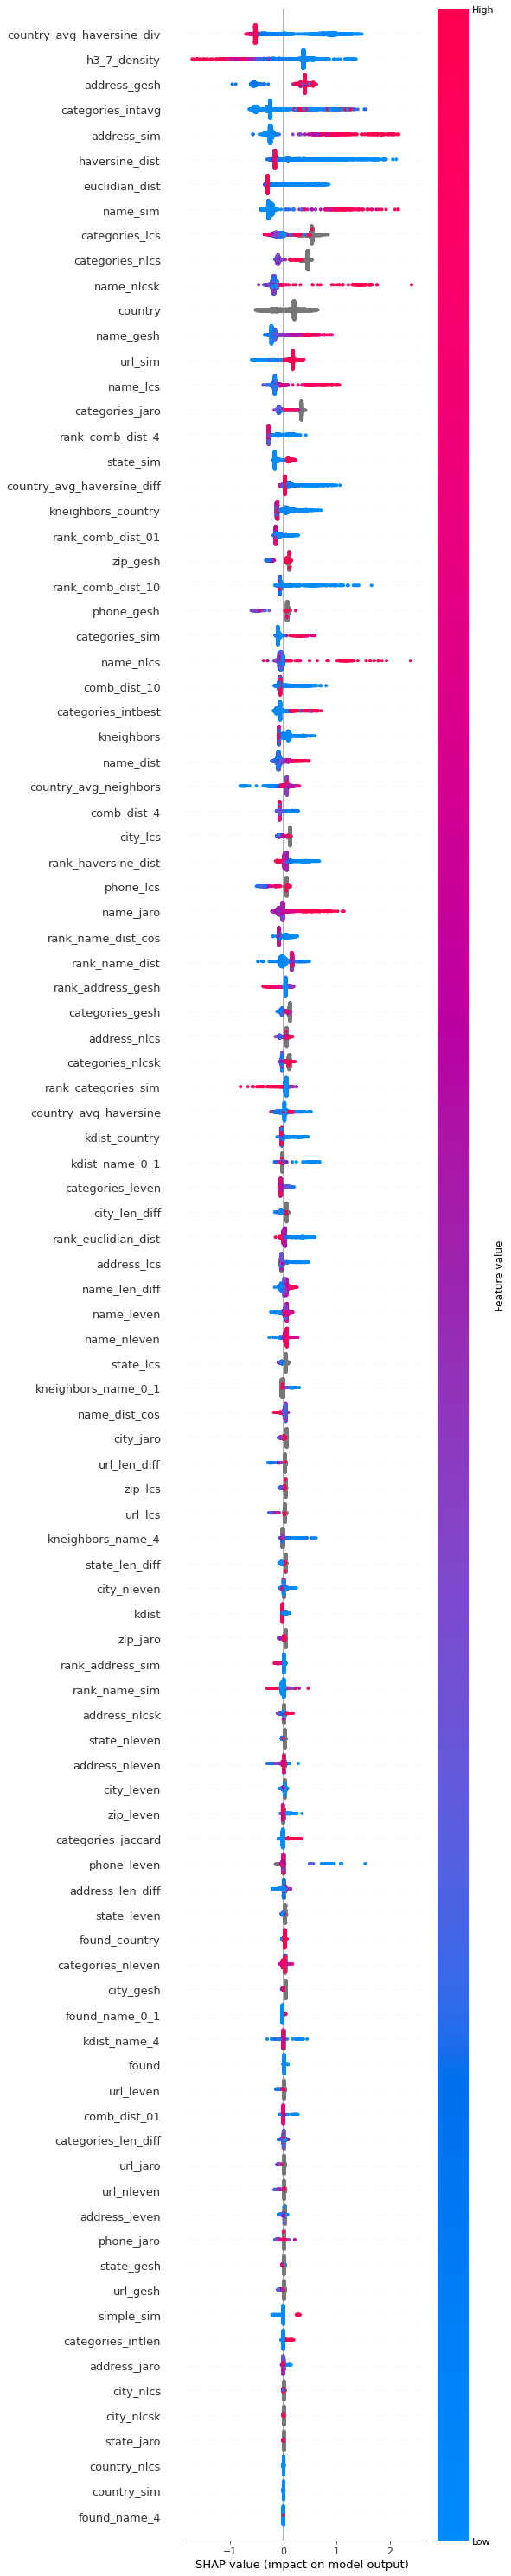

In [51]:
import shap
shap.initjs()
shap.summary_plot(shap_values, val_df[train_cols].iloc[first:last, :], max_display=100)